In [48]:
# 左右眼实验

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import cv2
import gc
import copy

import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD,Adam

Using TensorFlow backend.
/home/healgoo/.pyenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 从图片服务器download图片

In [4]:
PATH = './source_labels/'

In [5]:
filelist =  os.listdir(PATH)
filelist

['kaggle.csv', 'nine.csv', 'lingtou.csv', 'file_url']

### Alert！‘lingtou’队列label有误，巨坑mmp！

In [6]:
dataset_kaggle = pd.read_csv(PATH + filelist[0], index_col = False)
dataset_nine = pd.read_csv(PATH + filelist[1], index_col = False)
dataset_lingtou = pd.read_csv(PATH + filelist[2], index_col = None)

In [7]:
dataset_lingtou.head(5)

file_dir                      filename eye
0  /home/3t-raid1/fundus  5a5eff8a2b19ef43b64bd7c8.jpg   L
1  /home/3t-raid1/fundus  5a5eff8a2b19ef43b64bd7ca.jpg   R
2  /home/3t-raid1/fundus  5a5eff8a2b19ef43b64bd7cc.jpg   L
3  /home/3t-raid1/fundus  5a5eff8a2b19ef43b64bd7ce.jpg   R
4  /home/3t-raid1/fundus  5a5eff8a2b19ef43b64bd7d0.jpg   R

In [8]:
filename_kaggle = np.array(dataset_kaggle[['filename','eye']][0:2000])
# filename_kaggle = list(filename_kaggle)
filename_nine = np.array(dataset_nine[['filename','eye']])
filename_lingtou = np.array(dataset_lingtou[['filename','eye']])

In [35]:
ROUTE = 'http://192.168.1.139:3333/fundus/'
url_list_kaggle = [ROUTE + x[0] for x in filename_kaggle]
url_list_nine = [ROUTE + x[0] for x in filename_nine]
url_list_lingtou = [ROUTE + x[0] for x in filename_lingtou]
# file_url_list = 

In [36]:
file_url_list = url_list_kaggle + url_list_lingtou + url_list_nine

In [37]:
with open(PATH + 'file_url', 'a+') as f:
    f.writelines([x + '\n' for x in file_url_list])

In [9]:
filename_kaggle
filename_nine
filename_lingtou

array([['5a5eff8a2b19ef43b64bd7c8.jpg', 'L'],
       ['5a5eff8a2b19ef43b64bd7ca.jpg', 'R'],
       ['5a5eff8a2b19ef43b64bd7cc.jpg', 'L'],
       ...,
       ['5a5f006a2b19ef43b64c5d6e.jpg', 'L'],
       ['5a5f006a2b19ef43b64c5d70.jpg', 'L'],
       ['5a5f006a2b19ef43b64c5d72.jpg', 'L']], dtype=object)

In [10]:
# L -- 1 R -- 0
filename_nine[:,1][filename_nine[:,1] == 'R'] = 0
filename_nine[:,1][filename_nine[:,1] == 'L'] = 1

In [11]:
filename_lingtou[:,1][filename_lingtou[:,1] == 'R'] = 0
filename_lingtou[:,1][filename_lingtou[:,1] == 'L'] = 1

In [12]:
lingtou_left_count = filename_lingtou[:,1].sum()
lingtou_right_count = filename_lingtou.shape[0] - filename_lingtou[:,1].sum()
print(lingtou_left_count,lingtou_right_count)

10716 6190


In [13]:
nine_left_count = filename_nine[:,1].sum()
nine_right_count = filename_nine.shape[0] - filename_nine[:,1].sum()
print(nine_left_count,nine_right_count)

9151 9243


In [1032]:
9151+9243
18394*0.2


3678.8

In [14]:
kaggle_left_count = filename_kaggle[:,1].sum()
kaggle_right_count = filename_kaggle.shape[0] - filename_kaggle[:,1].sum()
print(kaggle_left_count,kaggle_right_count)

1000 1000


In [15]:
len(file_url_list)

NameError: name 'file_url_list' is not defined

## 不同预处理方法的性能比较

In [16]:
file_list_pre = filename_nine

In [17]:
file_list_pre[0]

array(['5a5efe462b19ef43b64b4814.jpg', 0], dtype=object)

In [18]:
np.random.shuffle(file_list_pre)

In [19]:
file_list_pre = file_list_pre[0:500]

In [20]:
file_list_pre.shape

(500, 2)

In [21]:
train_x = file_list_pre[:,0].astype('str')

In [22]:
train_y = file_list_pre[:,1].astype('int')

In [23]:
train_x[10:20]

array(['5a5efe852b19ef43b64b61f6.jpg', '5a5efe782b19ef43b64b5bf2.jpg',
       '5a5efeff2b19ef43b64b9704.jpg', '5a5eff862b19ef43b64bd2f2.jpg',
       '5a5efe992b19ef43b64b6acc.jpg', '5a5efe942b19ef43b64b684e.jpg',
       '5a5eff682b19ef43b64bc00a.jpg', '5a5efe7b2b19ef43b64b5d8c.jpg',
       '5a5efeed2b19ef43b64b8fde.jpg', '5a5efe8e2b19ef43b64b6666.jpg'],
      dtype='<U28')

In [24]:
train_y[10:20]

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1])

In [25]:
def shape_read(file_path, file_list):
    """Read image shape from directory.
    
    Args:
        file_path: directory path
        file_list: type: list; image file list
    Return:
        img_shape_list: a list of image shape
    """

    img_shape_list = []
    for file in file_list:
        print(file)
        p = ''.join([file_path, file])
        print(p)
        img = cv2.imread(p,1)
        img_shape_list.append(img.shape)
        gc.collect()
        
    return(img_shape_list)

In [26]:
def shape_check(img_shape_list, *args):
    """Check image shape by target shapes
    Args:
        img_shape_list: a list of image shape
        *args: target shapes
    Return:
        Boolean
    """
    
    count_list = []
    for arg in args:
        count = 0
#         print(arg)
        
        if arg not in img_shape_list:
            print('Target shape{} is not in shape list'.format(arg))
            
        for img_shape in img_shape_list:
            if img_shape == arg:
                count += 1
    
        count_list.append(count)
        
    print('Shapes checked {}'.format(sum(count_list)))   
    if sum(count_list) != len(img_shape_list):
        print('There are extra shapes in shape list')
        return False
    else: 
        return True

In [56]:
# shape_check(img_shape_list,(1920, 2560, 3),(1980, 2000, 3))

# shape_check(img_shape_list,(1920, 2560, 3))

shape_check(img_shape_list,(1920, 2560, 3),(1982, 2000, 3))

NameError: name 'img_shape_list' is not defined

In [505]:
def image_resize(img, shape):
    """Resize different image sizes to shape by clip and cv2.resize()
    Args:
        img: source image array
        shape: target resize shape
    Return:
        type array, resized image
    """
    scale = img.shape[0] / img.shape[1]
#     print(scale)
    if 0.9 <= scale < 1:
        return cv2.resize(img,shape,interpolation = cv2.INTER_NEAREST)
    else:
        length = img.shape[1]
        width = img.shape[0]
        
        # find attention area edge by moving check line i = img[:,i]
        index = 0
        index_move = True
        while index_move:
            index += 1
            if np.sum(img[:,index] == 0) != width*3:
                index_move = False
#         print(index,index_move)       
        # clip        
        img = img[:, index : length-index]
        
        return cv2.resize(img,shape,interpolation = cv2.INTER_NEAREST)

In [30]:
def image_enhance(img,method):
    """Enhance image by 'origin', 'clahe', 'lac'
    Args:
        img: a image array with shape (299,299,3)
        method: 'origin','clahe','gray','LAC'
    Return:
        enhanced image.
    """
    def mask_image(img):
        SCALE = 299 // 2
        mask = np.zeros((299,299,3))
        cv2.circle(mask,(SCALE,SCALE),int(SCALE * 0.95),(1,1,1),-1,8,0)
        return (img * mask + 128 * (1-mask)).astype(np.uint8)
    
    if img.shape != (299,299,3):
        print('Image shape is wrong, required (299,299,3)')
    else:             
        if method == 'origin':
            return mask_image(img)
        
        elif method == 'clahe':
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  
            img_1 = clahe.apply(img[:,:,0]) * 1
            img_2 = clahe.apply(img[:,:,1]) * 1
            img_3 = clahe.apply(img[:,:,2]) * 1
            return mask_image(cv2.merge([img_1,img_2,img_3]))
        
        elif method == 'LAC':
            return mask_image(cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 5), -4, 128))
        
        elif method in ['grey','gray']:        
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#             # gamma 滤波
#             gamma=copy.deepcopy(gray)  
#             rows=img.shape[0]  
#             cols=img.shape[1]  
#             for i in range(rows):  
#                 for j in range(cols):  
#                     gamma[i][j]=3*pow(gamma[i][j],0.8) 
            return mask_image(cv2.merge([gray,gray,gray]))

        else:
            print('Method not supported!')

In [59]:
img2_n = cv2.imread(''.join(['./source_images/',train_x[32]]))
img2_n = image_resize(img2_n, (299,299))

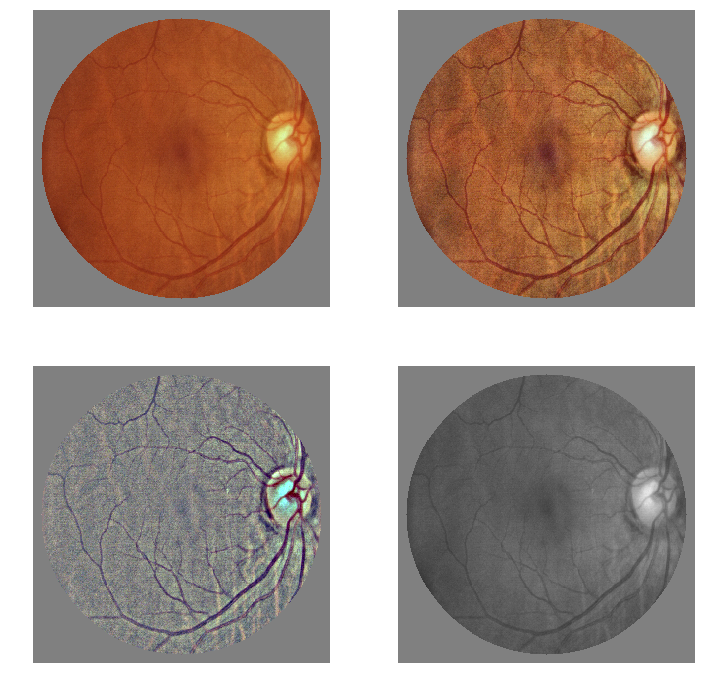

In [60]:
f = plt.figure(figsize=(12,12))
a1 = f.add_subplot(221)
a2 = f.add_subplot(222)
a3 = f.add_subplot(223)
a4 = f.add_subplot(224)

a1.imshow(image_enhance(img2_n,method = 'origin')[:,:,::-1], cmap = 'gray')
a2.imshow(image_enhance(img2_n,method = 'clahe')[:,:,::-1], cmap = 'gray')
a3.imshow(image_enhance(img2_n,method = 'LAC')[:,:,::-1], cmap = 'gray')
a4.imshow(image_enhance(img2_n,method = 'gray')[:,:,::-1], cmap = 'gray')
a1.axis('off')
a2.axis('off')
a3.axis('off')
a4.axis('off')
plt.show()
# ax.set_yticks([])
# plt.imshow(image_enhance(img2_n,method = 'gray')[:,:,::-1], cmap = 'gray')

In [61]:
train_x.shape

(500,)

In [198]:
def image_load(image_path, images, method):
    """Load images for directory.
    Args:
        image_path: path of directory
        images: images name list. type: list
        method: enhanced mathod
    Return:
        list of image arrays.
    """
    X = []
    image_shape_list = []
    count = 0
    for name in images:
        print(name)
        img = cv2.imread(''.join([image_path, name]), 1)
        img = image_resize(img, (299,299))
        img = image_enhance(img, method = method)
        
        X.append(img)
        image_shape_list.append(img.shape)
        count += 1
        print("{:.2f}% images processed".format(count/len(images)*100), end='\r')
    print('\n')
    print('{} images have been loaded and preprocessed'.format(count))
    
    if shape_check(image_shape_list, (299,299,3)):
        return X
    else:
#         print(shape_check(image_shape_list, (299,299,3)))
        print('Maybe some wrong shapes exist!')

In [88]:
X_origin = image_load('./source_images/', train_x, 'origin')

100.00% images processed

500 images have been loaded and preprocessed
Shapes checked 500


In [99]:
X_clahe = image_load('./source_images/', train_x, 'clahe')

100.00% images processed

500 images have been loaded and preprocessed
Shapes checked 500


In [31]:
X_gray = image_load('./source_images/', train_x, 'gray')

100.00% images processed

500 images have been loaded and preprocessed
Shapes checked 500


In [117]:
X_lac = image_load('./source_images/', train_x, 'LAC')

100.00% images processed

500 images have been loaded and preprocessed
Shapes checked 500


![imag](http://image107.360doc.com/DownloadImg/2017/06/2410/102635711_2.png)

In [131]:
def simple_model(input_shape = (299,299,3)):
    """A simple CNN model
    Return: a keras model
    """
    model = Sequential()
    # input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
    # this applies 32 convolution filters of size 3x3 each.
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
#     optimizer = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    optimizer = keras.optimizers.SGD(lr=0.05, momentum=0.0, decay=0.01, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = simple_model()

In [79]:
for i,layer in enumerate(model.layers):
    print(i,'-->',layer.name,layer.input_shape,layer.output_shape)

0 --> conv2d_17 (None, 299, 299, 3) (None, 297, 297, 64)
1 --> max_pooling2d_11 (None, 297, 297, 64) (None, 148, 148, 64)
2 --> conv2d_18 (None, 148, 148, 64) (None, 146, 146, 128)
3 --> dropout_11 (None, 146, 146, 128) (None, 146, 146, 128)
4 --> max_pooling2d_12 (None, 146, 146, 128) (None, 73, 73, 128)
5 --> conv2d_19 (None, 73, 73, 128) (None, 71, 71, 256)
6 --> conv2d_20 (None, 71, 71, 256) (None, 69, 69, 256)
7 --> max_pooling2d_13 (None, 69, 69, 256) (None, 34, 34, 256)
8 --> dropout_12 (None, 34, 34, 256) (None, 34, 34, 256)
9 --> conv2d_21 (None, 34, 34, 256) (None, 32, 32, 512)
10 --> conv2d_22 (None, 32, 32, 512) (None, 30, 30, 512)
11 --> max_pooling2d_14 (None, 30, 30, 512) (None, 15, 15, 512)
12 --> dropout_13 (None, 15, 15, 512) (None, 15, 15, 512)
13 --> conv2d_23 (None, 15, 15, 512) (None, 13, 13, 512)
14 --> conv2d_24 (None, 13, 13, 512) (None, 11, 11, 512)
15 --> max_pooling2d_15 (None, 11, 11, 512) (None, 5, 5, 512)
16 --> dropout_14 (None, 5, 5, 512) (None, 5, 5, 5

In [39]:
from keras.utils import plot_model
plot_model(model, to_file='./preprocessing_method/model.png')

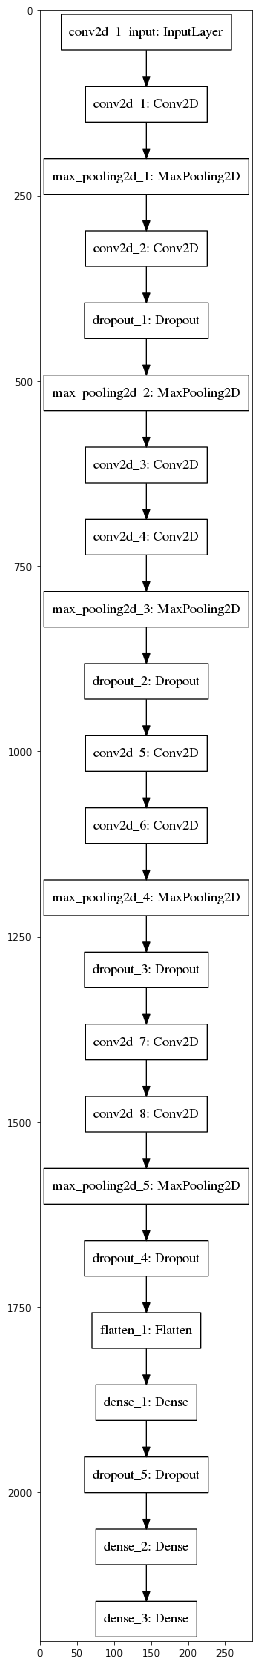

In [40]:
model_pic = cv2.imread('./preprocessing_method/model.png',1)
plt.figure(figsize=(50,30))
plt.imshow(model_pic)

In [114]:
gc.collect()

418

In [119]:
def train_model(model,data,label,batch_size,epoch):
    """Train model
    Args: 
        model: a keras model
        data: image data array
        label: label array (without one-hot encoder)
        batch_size
    Return:
        a keras History object
    """
    from keras.utils.np_utils import to_categorical
    label = to_categorical(label, num_classes=2)
    
    index = int(data.shape[0] * 0.8)
    train_X = data[0:index]
    train_y = label[0:index]
    
    valid_X = data[index:]
    valid_y = label[index:]
#     flow(self, X, y, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png')
    data_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1. / 255)
    train_generator = data_gen.flow(train_X, train_y, batch_size = batch_size)
    valid_generator = data_gen.flow(valid_X, valid_y, batch_size = batch_size)
    
    tf_record = keras.callbacks.TensorBoard(log_dir='./preprocessing_method/logs/lac2/')
    
    return model.fit_generator(train_generator, 
                        steps_per_epoch = train_X.shape[0] // batch_size, 
                        epochs=epoch, 
                        verbose=1, 
                        validation_data=valid_generator, 
                        validation_steps= valid_X.shape[0] // batch_size,
                        callbacks = [tf_record])

In [120]:
# train_y = np.asarray(train_y)
# X_origin = np.asarray(X_origin)
# X_clahe = np.asarray(X_clahe)
# X_gray = np.asarray(X_gray)
X_lac = np.asarray(X_lac)

0


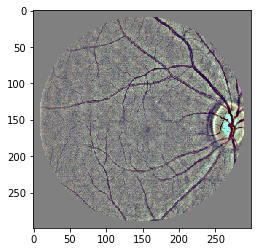

In [121]:
# for i in range(10):
i=130
plt.imshow(X_lac[i][:,:,::-1])
print(train_y[i])

In [384]:
# with open("./preprocessing_method/x.pkl", "wb") as f:
#     pk.dump(X_lac, f)
# with open("./preprocessing_method/y.pkl", "wb") as f:
#     pk.dump(train_y, f) 

In [5]:
# import pickle as pk
# with open("./preprocessing_method/x.pkl", "rb") as f:
#     X_lac = pk.load(f)
# with open("./preprocessing_method/y.pkl", "rb") as f:
#     train_y = pk.load(f)

In [70]:
X_lac.shape
train_y.shape

(500,)

In [132]:
his = train_model(model, X_lac, train_y, 18, 500)

Epoch 1/500
22/22 [==============================] - 9s 391ms/step - loss: 0.6948 - acc: 0.5143 - val_loss: 0.6912 - val_acc: 0.5333
Epoch 2/500
22/22 [==============================] - 9s 387ms/step - loss: 0.6929 - acc: 0.5379 - val_loss: 0.6875 - val_acc: 0.5854
Epoch 3/500
22/22 [==============================] - 9s 387ms/step - loss: 0.6904 - acc: 0.5489 - val_loss: 0.7118 - val_acc: 0.4146
Epoch 4/500
22/22 [==============================] - 9s 401ms/step - loss: 0.6932 - acc: 0.5253 - val_loss: 0.6815 - val_acc: 0.5976
Epoch 5/500
22/22 [==============================] - 9s 387ms/step - loss: 0.6893 - acc: 0.5430 - val_loss: 0.6950 - val_acc: 0.5122
Epoch 6/500
22/22 [==============================] - 8s 374ms/step - loss: 0.6937 - acc: 0.5338 - val_loss: 0.6902 - val_acc: 0.5366
Epoch 7/500
22/22 [==============================] - 9s 401ms/step - loss: 0.6927 - acc: 0.5253 - val_loss: 0.6930 - val_acc: 0.5111
Epoch 8/500
22/22 [==============================] - 8s 377ms/step - 

22/22 [==============================] - 9s 403ms/step - loss: 0.2312 - acc: 0.8990 - val_loss: 0.2368 - val_acc: 0.8659
Epoch 124/500
22/22 [==============================] - 8s 378ms/step - loss: 0.2330 - acc: 0.9316 - val_loss: 0.3345 - val_acc: 0.8537
Epoch 125/500
22/22 [==============================] - 9s 389ms/step - loss: 0.2508 - acc: 0.8963 - val_loss: 0.3468 - val_acc: 0.8171
Epoch 126/500
22/22 [==============================] - 9s 402ms/step - loss: 0.2369 - acc: 0.9141 - val_loss: 0.3167 - val_acc: 0.8293
Epoch 127/500
22/22 [==============================] - 9s 391ms/step - loss: 0.2102 - acc: 0.9089 - val_loss: 0.3043 - val_acc: 0.8333
Epoch 128/500
22/22 [==============================] - 9s 389ms/step - loss: 0.2496 - acc: 0.9140 - val_loss: 0.2528 - val_acc: 0.8659
Epoch 129/500
22/22 [==============================] - 8s 378ms/step - loss: 0.2300 - acc: 0.9079 - val_loss: 0.3469 - val_acc: 0.8537
Epoch 130/500
22/22 [==============================] - 9s 390ms/step 

Epoch 184/500
22/22 [==============================] - 9s 392ms/step - loss: 0.1649 - acc: 0.9368 - val_loss: 0.3526 - val_acc: 0.8415
Epoch 185/500
22/22 [==============================] - 9s 401ms/step - loss: 0.1269 - acc: 0.9520 - val_loss: 0.2861 - val_acc: 0.8537
Epoch 186/500
22/22 [==============================] - 8s 378ms/step - loss: 0.1426 - acc: 0.9493 - val_loss: 0.3191 - val_acc: 0.8415
Epoch 187/500
22/22 [==============================] - 9s 391ms/step - loss: 0.1881 - acc: 0.9368 - val_loss: 0.3176 - val_acc: 0.8667
Epoch 188/500
22/22 [==============================] - 9s 392ms/step - loss: 0.1527 - acc: 0.9469 - val_loss: 0.3201 - val_acc: 0.8537
Epoch 189/500
22/22 [==============================] - 9s 391ms/step - loss: 0.1290 - acc: 0.9545 - val_loss: 0.3336 - val_acc: 0.8537
Epoch 190/500
22/22 [==============================] - 9s 391ms/step - loss: 0.1654 - acc: 0.9384 - val_loss: 0.2946 - val_acc: 0.8780
Epoch 191/500
22/22 [==============================] - 

Epoch 245/500
22/22 [==============================] - 8s 377ms/step - loss: 0.1007 - acc: 0.9595 - val_loss: 0.3885 - val_acc: 0.8049
Epoch 246/500
22/22 [==============================] - 9s 401ms/step - loss: 0.1058 - acc: 0.9773 - val_loss: 0.2792 - val_acc: 0.8902
Epoch 247/500
22/22 [==============================] - 9s 391ms/step - loss: 0.1004 - acc: 0.9696 - val_loss: 0.2856 - val_acc: 0.8889
Epoch 248/500
22/22 [==============================] - 9s 391ms/step - loss: 0.1036 - acc: 0.9747 - val_loss: 0.3519 - val_acc: 0.8537
Epoch 249/500
22/22 [==============================] - 9s 390ms/step - loss: 0.0960 - acc: 0.9722 - val_loss: 0.3868 - val_acc: 0.8415
Epoch 250/500
22/22 [==============================] - 9s 389ms/step - loss: 0.1292 - acc: 0.9511 - val_loss: 0.2954 - val_acc: 0.8780
Epoch 251/500
22/22 [==============================] - 9s 388ms/step - loss: 0.1189 - acc: 0.9621 - val_loss: 0.2446 - val_acc: 0.8902
Epoch 252/500
22/22 [==============================] - 

Epoch 306/500
22/22 [==============================] - 9s 389ms/step - loss: 0.0942 - acc: 0.9696 - val_loss: 0.3632 - val_acc: 0.8659
Epoch 307/500
22/22 [==============================] - 9s 390ms/step - loss: 0.0582 - acc: 0.9899 - val_loss: 0.3237 - val_acc: 0.9111
Epoch 308/500
22/22 [==============================] - 9s 389ms/step - loss: 0.0796 - acc: 0.9722 - val_loss: 0.4559 - val_acc: 0.8537
Epoch 309/500
22/22 [==============================] - 9s 389ms/step - loss: 0.0821 - acc: 0.9696 - val_loss: 0.2912 - val_acc: 0.9146
Epoch 310/500
22/22 [==============================] - 9s 390ms/step - loss: 0.0508 - acc: 0.9899 - val_loss: 0.4477 - val_acc: 0.8293
Epoch 311/500
22/22 [==============================] - 9s 388ms/step - loss: 0.0814 - acc: 0.9798 - val_loss: 0.3640 - val_acc: 0.8415
Epoch 312/500
22/22 [==============================] - 9s 388ms/step - loss: 0.0758 - acc: 0.9772 - val_loss: 0.3631 - val_acc: 0.8780
Epoch 313/500
22/22 [==============================] - 

Epoch 367/500
22/22 [==============================] - 9s 390ms/step - loss: 0.0645 - acc: 0.9874 - val_loss: 0.4031 - val_acc: 0.8889
Epoch 368/500
22/22 [==============================] - 9s 389ms/step - loss: 0.0660 - acc: 0.9874 - val_loss: 0.3609 - val_acc: 0.8902
Epoch 369/500
22/22 [==============================] - 9s 389ms/step - loss: 0.0574 - acc: 0.9713 - val_loss: 0.6314 - val_acc: 0.8293
Epoch 370/500
22/22 [==============================] - 9s 388ms/step - loss: 0.0523 - acc: 0.9848 - val_loss: 0.4455 - val_acc: 0.8415
Epoch 371/500
22/22 [==============================] - 9s 390ms/step - loss: 0.0727 - acc: 0.9772 - val_loss: 0.3531 - val_acc: 0.9390
Epoch 372/500
22/22 [==============================] - 9s 388ms/step - loss: 0.0542 - acc: 0.9798 - val_loss: 0.4510 - val_acc: 0.8659
Epoch 373/500
22/22 [==============================] - 9s 390ms/step - loss: 0.0481 - acc: 0.9848 - val_loss: 0.4342 - val_acc: 0.8889
Epoch 374/500
22/22 [==============================] - 

Epoch 428/500
22/22 [==============================] - 9s 390ms/step - loss: 0.0533 - acc: 0.9874 - val_loss: 0.4450 - val_acc: 0.8780
Epoch 429/500
22/22 [==============================] - 9s 401ms/step - loss: 0.0389 - acc: 0.9874 - val_loss: 0.4330 - val_acc: 0.8780
Epoch 430/500
22/22 [==============================] - 8s 377ms/step - loss: 0.0412 - acc: 0.9899 - val_loss: 0.5741 - val_acc: 0.8537
Epoch 431/500
22/22 [==============================] - 9s 401ms/step - loss: 0.0545 - acc: 0.9823 - val_loss: 0.3719 - val_acc: 0.9024
Epoch 432/500
22/22 [==============================] - 9s 387ms/step - loss: 0.0455 - acc: 0.9823 - val_loss: 0.5621 - val_acc: 0.8537
Epoch 433/500
22/22 [==============================] - 8s 378ms/step - loss: 0.0356 - acc: 0.9924 - val_loss: 0.4521 - val_acc: 0.8889
Epoch 434/500
22/22 [==============================] - 9s 400ms/step - loss: 0.0589 - acc: 0.9798 - val_loss: 0.5156 - val_acc: 0.8780
Epoch 435/500
22/22 [==============================] - 

Epoch 489/500
22/22 [==============================] - 8s 378ms/step - loss: 0.0311 - acc: 0.9949 - val_loss: 0.8032 - val_acc: 0.8293
Epoch 490/500
22/22 [==============================] - 9s 400ms/step - loss: 0.0377 - acc: 0.9949 - val_loss: 0.2668 - val_acc: 0.9024
Epoch 491/500
22/22 [==============================] - 8s 377ms/step - loss: 0.0491 - acc: 0.9848 - val_loss: 0.9074 - val_acc: 0.8049
Epoch 492/500
22/22 [==============================] - 9s 387ms/step - loss: 0.0245 - acc: 0.9949 - val_loss: 0.2126 - val_acc: 0.9268
Epoch 493/500
22/22 [==============================] - 9s 402ms/step - loss: 0.0482 - acc: 0.9899 - val_loss: 0.5738 - val_acc: 0.8556
Epoch 494/500
22/22 [==============================] - 9s 390ms/step - loss: 0.0307 - acc: 0.9949 - val_loss: 0.6186 - val_acc: 0.8293
Epoch 495/500
22/22 [==============================] - 9s 387ms/step - loss: 0.0438 - acc: 0.9874 - val_loss: 0.4000 - val_acc: 0.9024
Epoch 496/500
22/22 [==============================] - 

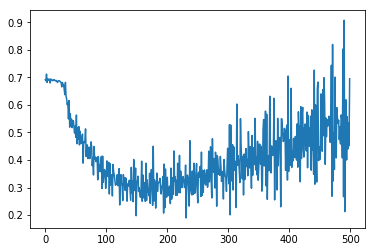

In [134]:
plt.plot(his.history['val_loss'])

In [37]:
import h5py as h5
import pickle as pk
# with h5.File("./preprocessing_method/history/history.h5", 'a') as f:
#     f.create_dataset('origin',data = his.history)
    
with open("./preprocessing_method/history/gray2.pkl", 'wb') as f:
    pk.dump(his.history,f)

In [38]:
model.save("./preprocessing_method/model/gray2.h5")

In [10]:
def draw_training(x_label, y_label, smooth_weight = 0.5, figure_size = (12,6), *args):
    """A fuction for drawing training lines with smooth
    Args:
        smooth: 0.0 - 1.0
        light: boolean
        x_label: string
        y_label: string
        *args: tuples. (data, color). Eg:(train_accuracy, 'red')
    """
#     return args
    # smooth fuction
    def smooth(scalars, weight):  # Weight between 0 and 1
        last = scalars[0]  # First value in the plot (first timestep)
        smoothed = list()
        for point in scalars:
            smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
            smoothed.append(smoothed_val)                        # Save it
            last = smoothed_val                                  # Anchor the last smoothed value
        return smoothed
    
    # check arguments
    
    if (0.0 <= smooth_weight <= 1.0 and isinstance(figure_size, tuple) and isinstance(x_label, str) 
    and isinstance(y_label, str)) is False:
        print("error input")
    else:
        labels = ['ORIGINAL','GRAY', 'CLAHE', 'LSACR']
        fig = plt.figure(figsize = figure_size, dpi = 400).add_subplot(111)
         
        for i,arg in enumerate(args):      
            if smooth_weight != 0:
                s = smooth(arg[0], smooth_weight)
#                 fig.plot(s, color = ''.join(['light',arg[1]]))
#                 fig.plot(arg[0], color = ''.join(['light',arg[1]]))
                fig.plot(s, color = arg[1], label = labels[i])
            else: fig.plot(arg[0], color = arg[1])
        
        fig.set_xlabel(x_label,fontsize=15)
        fig.set_ylabel(y_label,fontsize=15)
        plt.grid('off')
        plt.legend(loc = 'best')
        plt.xlim([0.0, 260])
#         plt.ylim([0.0, 1.05])

In [6]:
# load history
import pickle
with open("./preprocessing_method/history/"+"origin.pkl",'rb') as f:
    origin_his = pickle.load(f)
with open("./preprocessing_method/history/"+"clahe.pkl",'rb') as f:
    clahe_his = pickle.load(f)
with open("./preprocessing_method/history/"+"lac.pkl",'rb') as f:
    lac_his = pickle.load(f)
with open("./preprocessing_method/history/"+"gray.pkl",'rb') as f:
    gray_his = pickle.load(f)

In [7]:
gray_val_loss = gray_his['val_loss'][0:250]
gray_val_acc = gray_his['val_acc'][0:250]

origin_val_loss = origin_his['val_loss'][0:250]
origin_val_acc = origin_his['val_acc'][0:250]

clahe_val_loss = clahe_his['val_loss'][0:250]
clahe_val_acc = clahe_his['val_acc'][0:250]

lac_val_loss = lac_his['val_loss'][0:250]
lac_val_acc = lac_his['val_acc'][0:250]

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


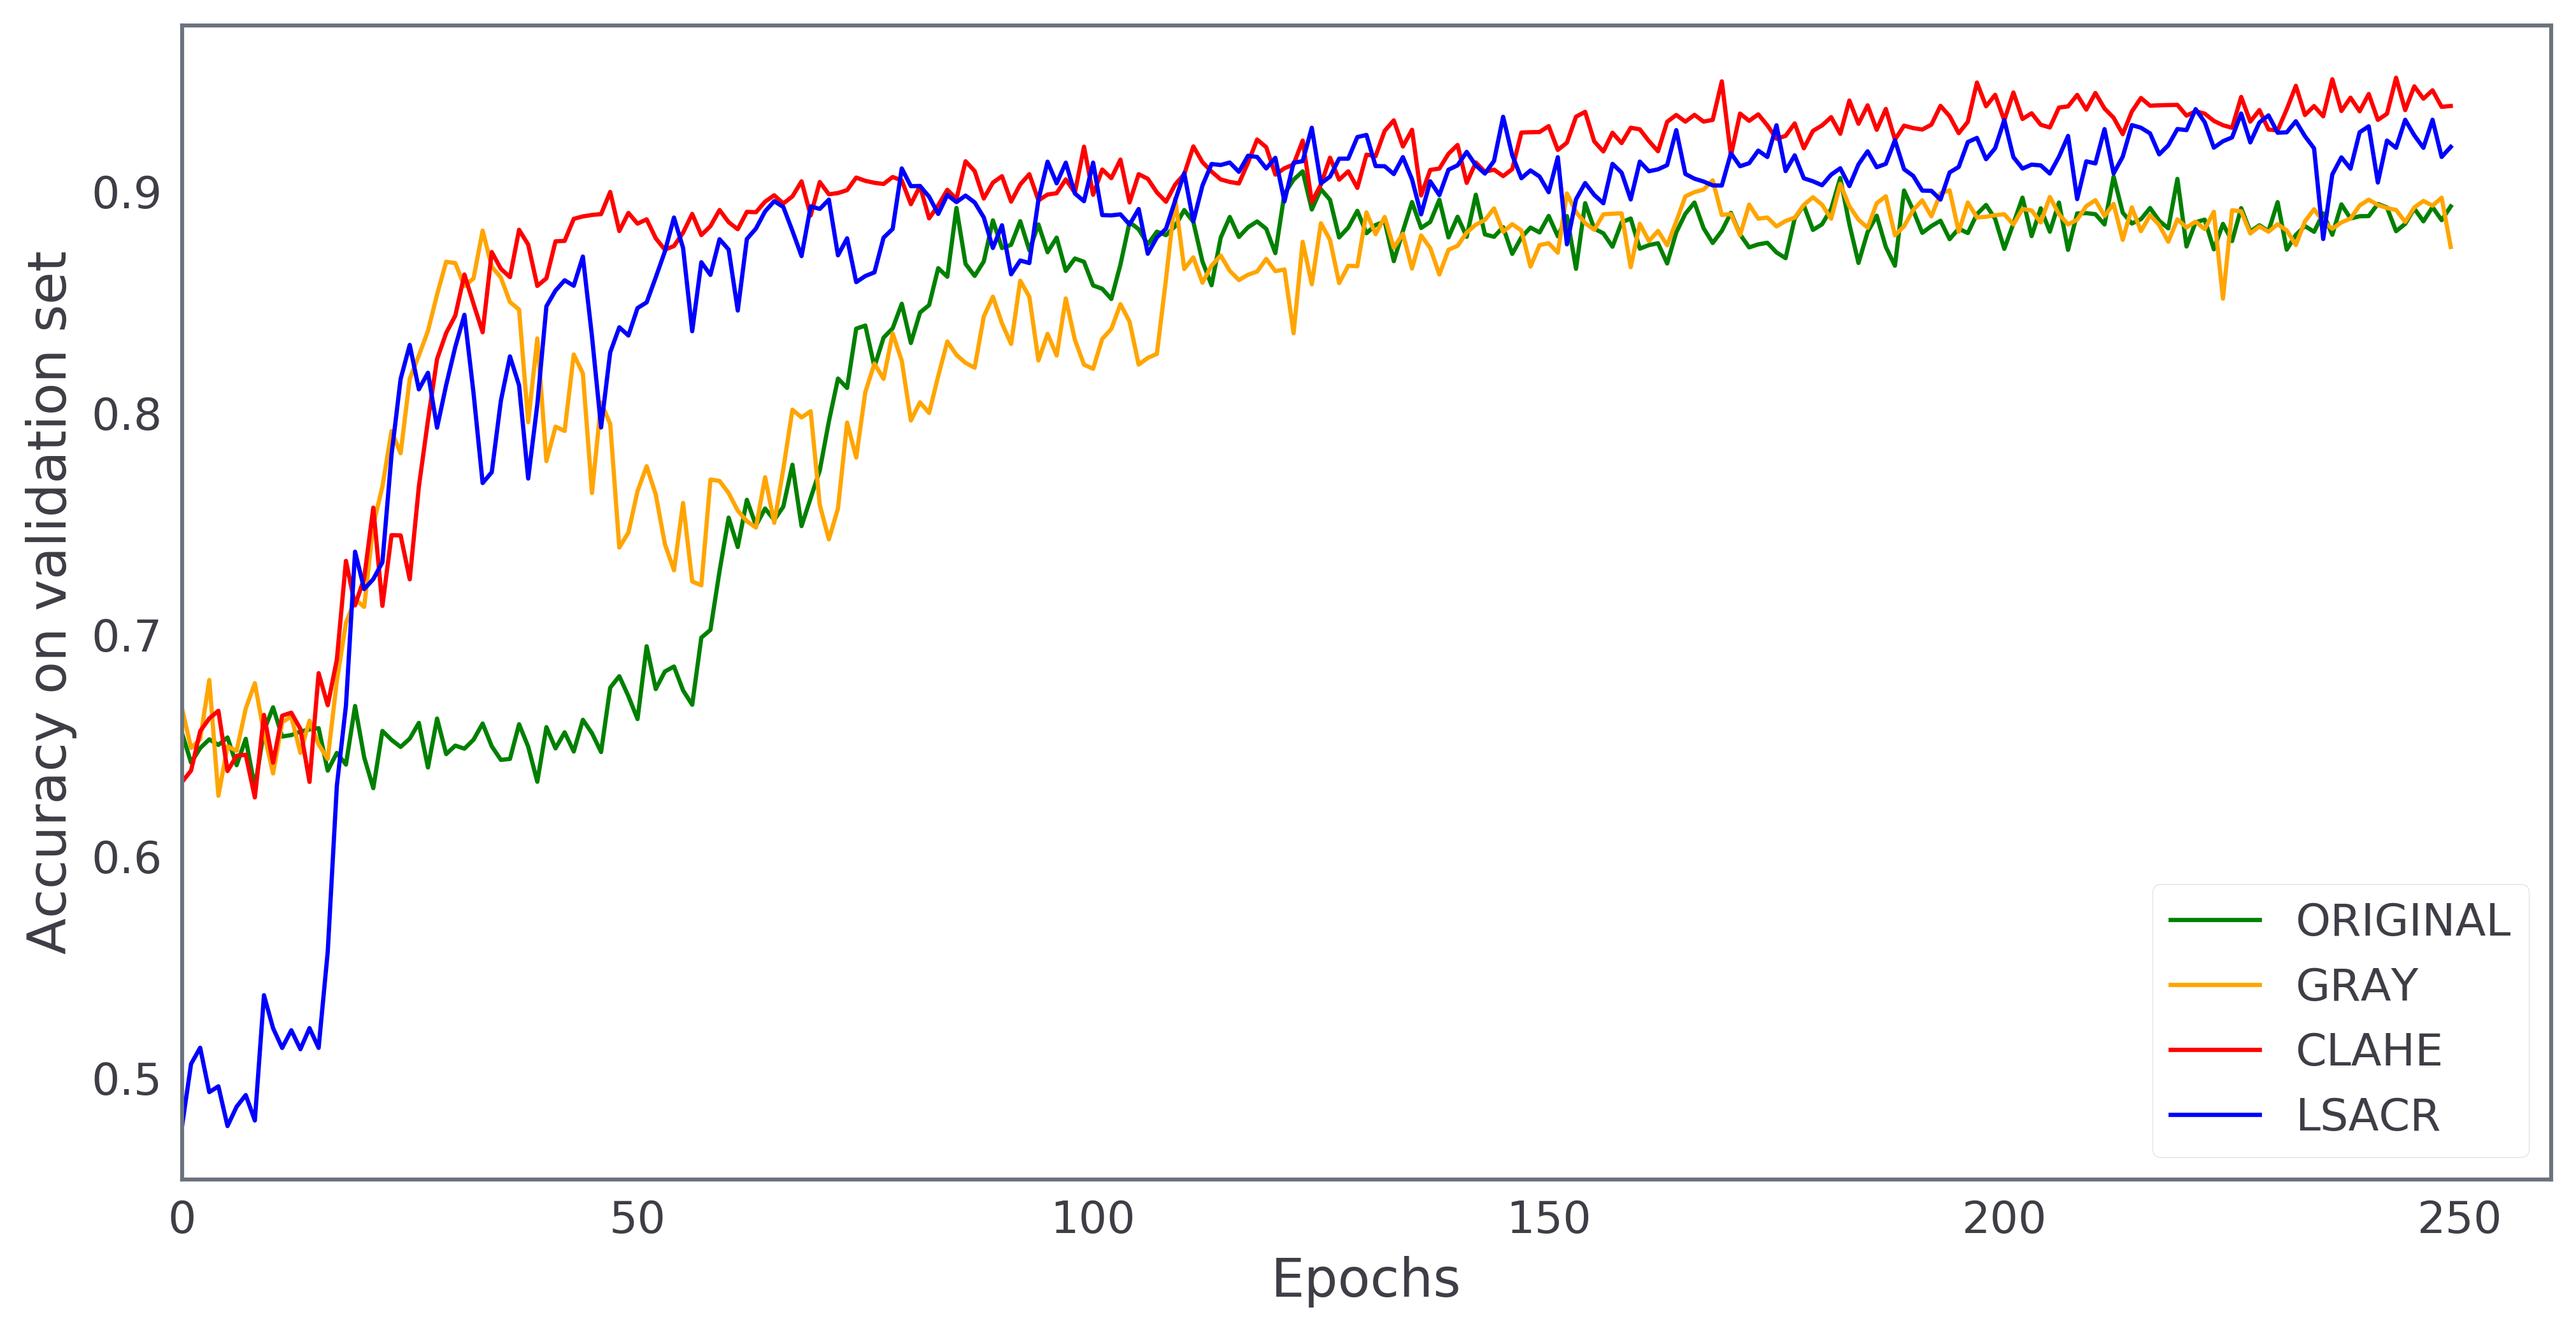

In [11]:
draw_training('Epochs', 'Accuracy on validation set',0.6,(12,6),
              
              (origin_val_acc,'green'),
              (gray_val_acc,'orange'),
              (clahe_val_acc,'red'),
              (lac_val_acc,'blue'))

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


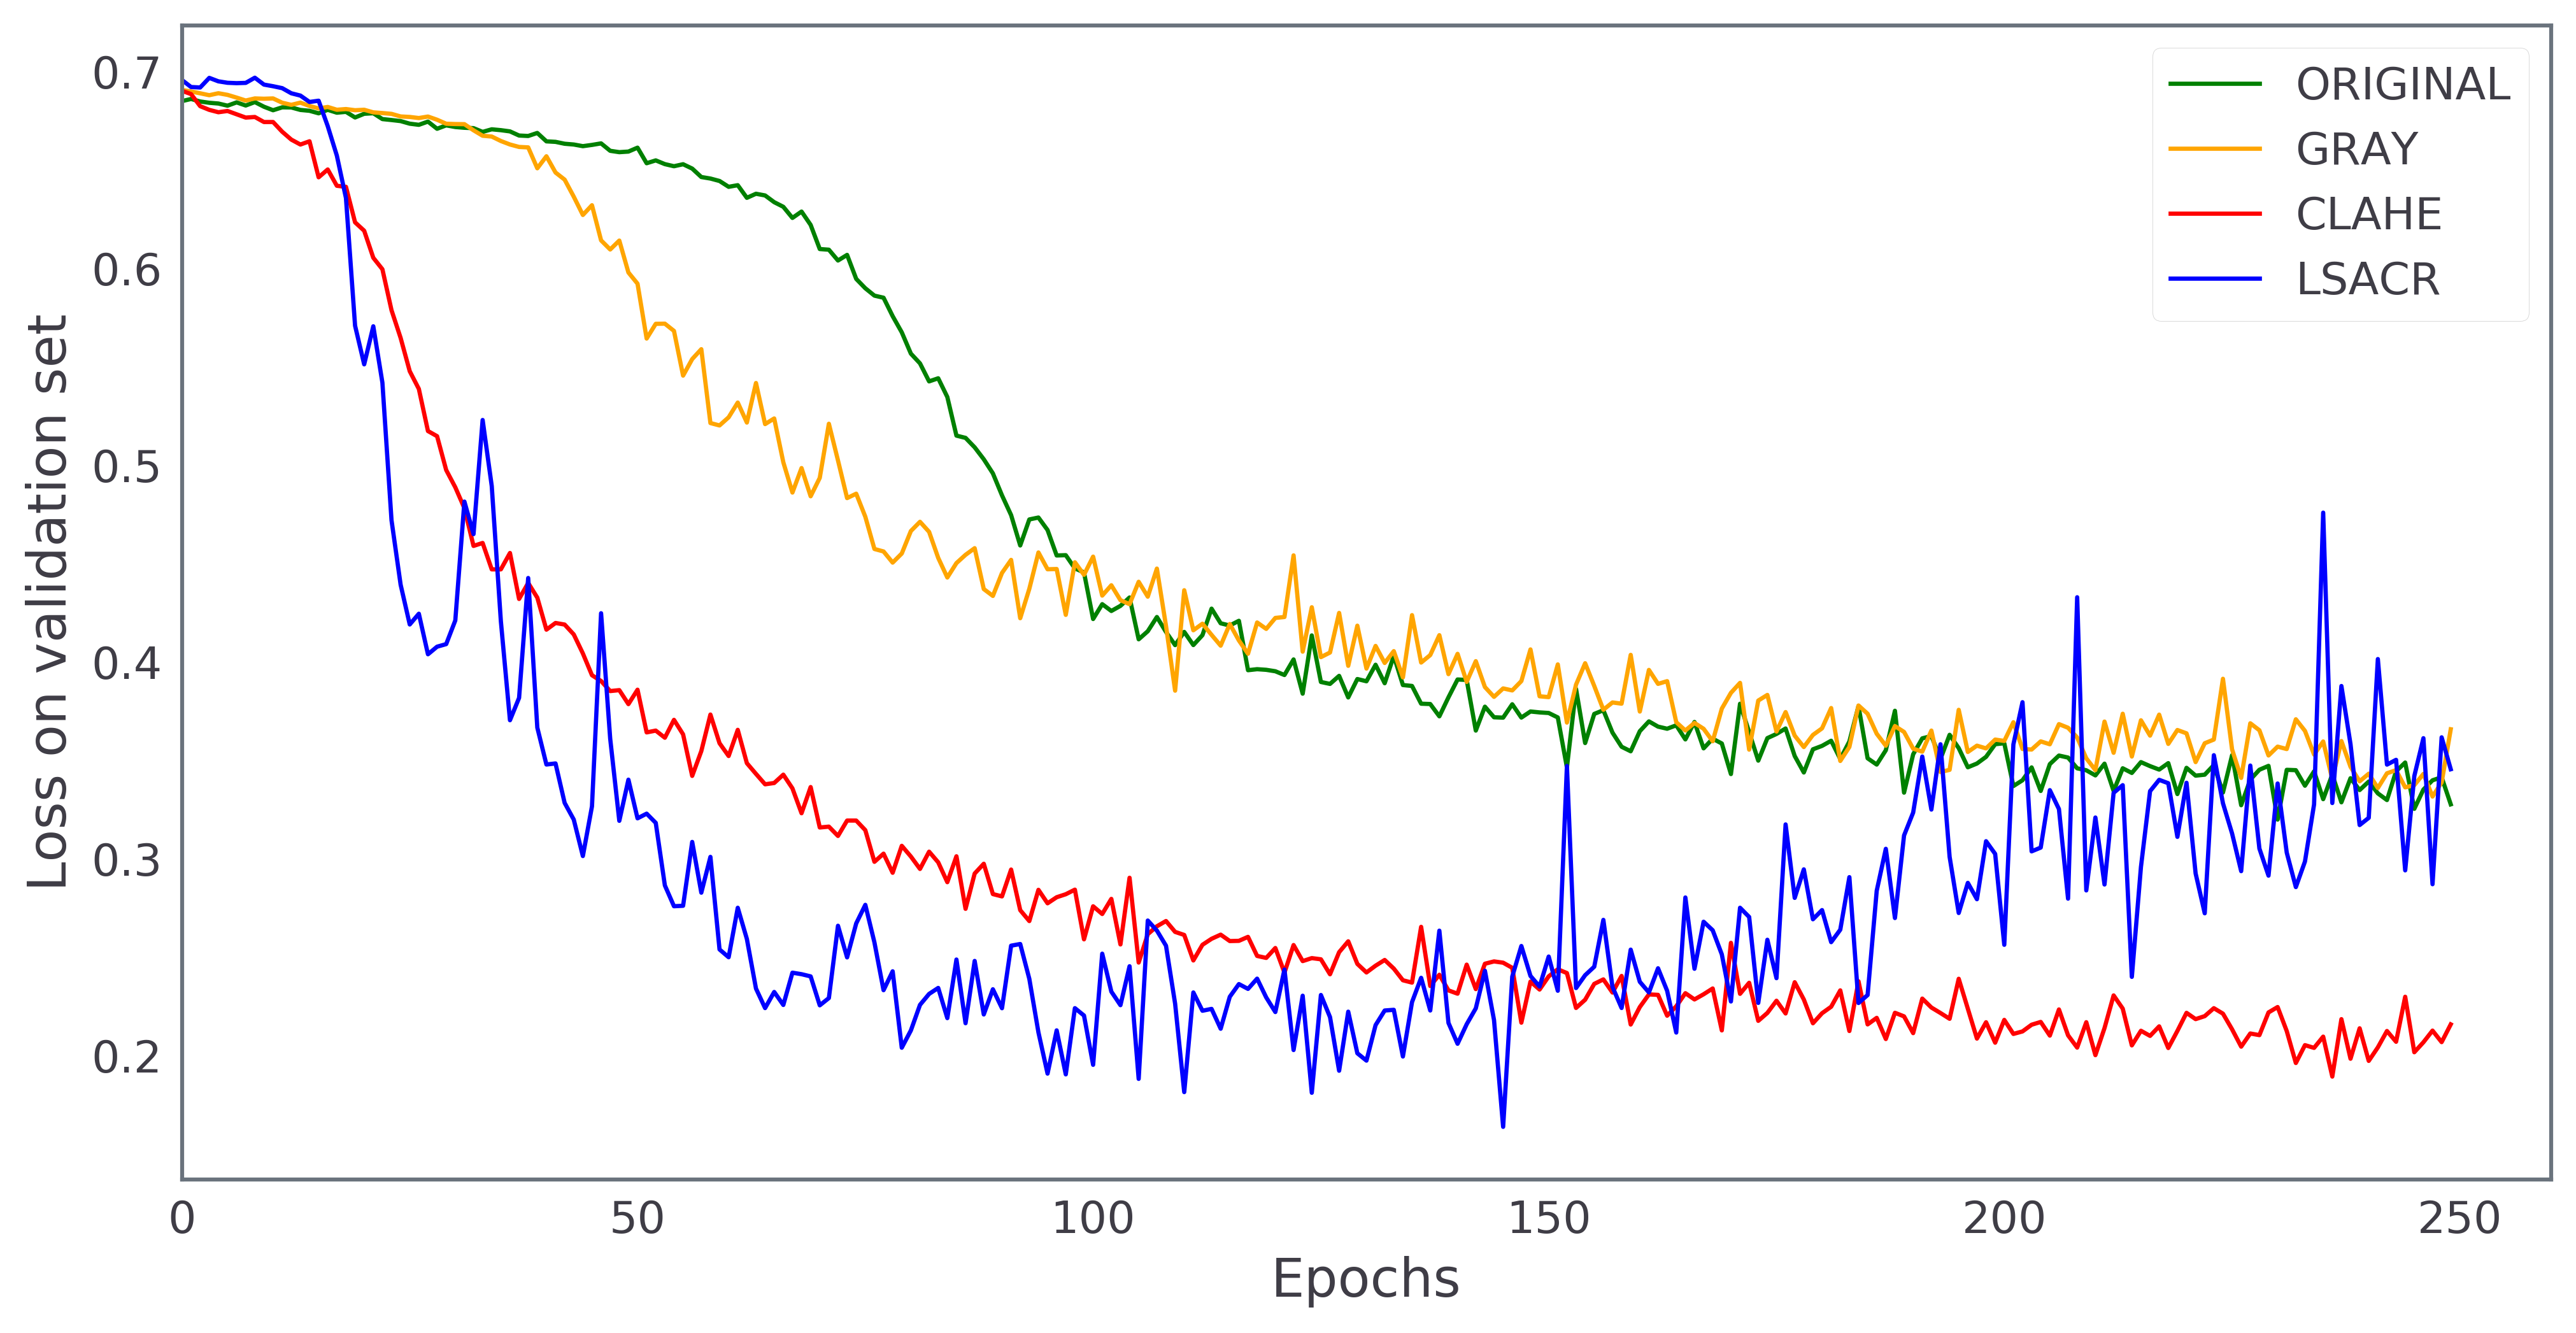

In [12]:

draw_training('Epochs','Loss on validation set', 0.5,(12,6),            
              (origin_val_loss,'green'),
              (gray_val_loss,'orange'),
              (clahe_val_loss,'red'),
             (lac_val_loss,'blue'))


## 不同模型的性能和可视化比较

- 本部分需要用到：
    - transfer learning
    - data augment
    - self-adaptive learning rate
    - self-adaptive reinforcement
    - 翻转测试
    - moving block
    - VGG-19, ResNet50, Inception V3, InceptionResNetV2, DenseNet, improved Net

- See 'train_diff_nets.ipynb'

## 结果分析

- 本部分需要用到：
    - 混淆矩阵
    - 临床分析

- 1.导入kaggle数据集和内部验证集

In [5]:
from keras.models import load_model
model = load_model('/home/liuchi/right_left/different_networks/model/inception/weights.165-0.099-0.9920.hdf5')

In [215]:
ROUTE = 'http://192.168.1.139:3333/fundus/'
url_list_kaggle = [ROUTE + x[0] for x in filename_kaggle]
# file_url_list = 

In [217]:
with open(PATH + 'kaggle_url', 'a+') as f:
    f.writelines([x + '\n' for x in url_list_kaggle])

In [193]:
test_X_name = filename_kaggle[:,0]
# test_y = filename_kaggle[:,1]

**！！！注意！！！**

> kaggle数据集中黑暗像素中也有值，所以要修改image_resize中选取attention area的判断逻辑

In [577]:
def image_resize(img, shape):
    """Resize different image sizes to shape by clip and cv2.resize()
    Args:
        img: source image array
        shape: target resize shape
    Return:
        type array, resized image
    """
    scale = img.shape[0] / img.shape[1]
#     print(scale)
    if 0.9 <= scale < 1:
        return cv2.resize(img,shape,interpolation = cv2.INTER_NEAREST)
    else:
        length = img.shape[1]
        width = img.shape[0]
        
        # find attention area edge by moving check line i = img[:,i]
        index = 0
        index_move = True
        while index_move:
            index += 1
            if np.sum(img[:,index]) > 30000:
                index_move = False
        print(index,index_move)       
        # clip        
        img = img[:, index : length-index]
        
        return cv2.resize(img,shape,interpolation = cv2.INTER_NEAREST)

In [578]:
test_X = image_load('./source_images/',test_X_name,'clahe')

59ef0cfa2b19ef60d5885f3e.jpeg
858 False
59ef0cfa2b19ef60d5885f3f.jpeg
866 False
59ef0cfa2b19ef60d5885f42.jpeg
862 False
59ef0cfa2b19ef60d5885f43.jpeg
862 False
59ef0cfa2b19ef60d5885f44.jpeg
333 False
59ef0cfa2b19ef60d5885f45.jpeg
340 False
59ef0cfa2b19ef60d5885f46.jpeg
708 False
59ef0cfa2b19ef60d5885f47.jpeg
708 False
59ef0cfb2b19ef60d5885f48.jpeg
701 False
59ef0cfb2b19ef60d5885f49.jpeg
701 False
59ef0cfb2b19ef60d5885f4a.jpeg
357 False
59ef0cfb2b19ef60d5885f4b.jpeg
356 False
59ef0cfb2b19ef60d5885f4c.jpeg
856 False
59ef0cfb2b19ef60d5885f4d.jpeg
861 False
59ef0cfb2b19ef60d5885f4e.jpeg
127 False
59ef0cfb2b19ef60d5885f4f.jpeg
127 False
59ef0cfb2b19ef60d5885f50.jpeg
701 False
59ef0cfb2b19ef60d5885f51.jpeg
705 False
59ef0cfb2b19ef60d5885f52.jpeg
348 False
59ef0cfb2b19ef60d5885f53.jpeg
335 False
59ef0cfb2b19ef60d5885f54.jpeg
127 False
59ef0cfb2b19ef60d5885f55.jpeg
128 False
59ef0cfb2b19ef60d5885f56.jpeg
867 False
59ef0cfb2b19ef60d5885f57.jpeg
867 False
59ef0cfb2b19ef60d5885f58.jpeg
896 False


878 False
59ef0d022b19ef60d5886010.jpeg
873 False
59ef0d022b19ef60d5886011.jpeg
873 False
59ef0d022b19ef60d5886012.jpeg
330 False
59ef0d022b19ef60d5886013.jpeg
332 False
59ef0d022b19ef60d5886014.jpeg
887 False
59ef0d022b19ef60d5886015.jpeg
888 False
59ef0d022b19ef60d5886016.jpeg
384 False
59ef0d022b19ef60d5886017.jpeg
348 False
59ef0d022b19ef60d5886018.jpeg
647 False
59ef0d022b19ef60d5886019.jpeg
649 False
59ef0d022b19ef60d588601a.jpeg
868 False
59ef0d022b19ef60d588601b.jpeg
869 False
59ef0d022b19ef60d588601c.jpeg
864 False
59ef0d022b19ef60d588601d.jpeg
866 False
59ef0d022b19ef60d588601e.jpeg
850 False
59ef0d022b19ef60d588601f.jpeg
853 False
59ef0d022b19ef60d5886020.jpeg
689 False
59ef0d022b19ef60d5886021.jpeg
691 False
59ef0d022b19ef60d5886022.jpeg
863 False
59ef0d022b19ef60d5886023.jpeg
864 False
59ef0d022b19ef60d5886024.jpeg
864 False
59ef0d022b19ef60d5886025.jpeg
864 False
59ef0d022b19ef60d5886026.jpeg
323 False
59ef0d022b19ef60d5886027.jpeg
326 False
59ef0d022b19ef60d5886028.jpeg


893 False
59ef0d082b19ef60d58860de.jpeg
294 False
59ef0d082b19ef60d58860df.jpeg
293 False
59ef0d082b19ef60d58860e0.jpeg
330 False
59ef0d082b19ef60d58860e1.jpeg
331 False
59ef0d082b19ef60d58860e2.jpeg
127 False
59ef0d082b19ef60d58860e3.jpeg
127 False
59ef0d082b19ef60d58860e4.jpeg
706 False
59ef0d082b19ef60d58860e5.jpeg
709 False
59ef0d082b19ef60d58860e8.jpeg
887 False
59ef0d082b19ef60d58860e9.jpeg
888 False
59ef0d082b19ef60d58860ea.jpeg
658 False
59ef0d082b19ef60d58860eb.jpeg
662 False
59ef0d082b19ef60d58860ec.jpeg
874 False
59ef0d082b19ef60d58860ed.jpeg
874 False
59ef0d082b19ef60d58860ee.jpeg
677 False
59ef0d082b19ef60d58860ef.jpeg
687 False
59ef0d082b19ef60d58860f0.jpeg
255 False
59ef0d082b19ef60d58860f1.jpeg
246 False
59ef0d082b19ef60d58860f2.jpeg
899 False
59ef0d082b19ef60d58860f3.jpeg
899 False
59ef0d082b19ef60d58860f4.jpeg
346 False
59ef0d082b19ef60d58860f5.jpeg
307 False
59ef0d082b19ef60d58860f6.jpeg
291 False
59ef0d082b19ef60d58860f7.jpeg
290 False
59ef0d092b19ef60d58860f8.jpeg


160 False
59ef0d0d2b19ef60d58861b2.jpeg
304 False
59ef0d0d2b19ef60d58861b3.jpeg
298 False
59ef0d0d2b19ef60d58861b4.jpeg
684 False
59ef0d0d2b19ef60d58861b5.jpeg
685 False
59ef0d0e2b19ef60d58861b8.jpeg
4 False
59ef0d0e2b19ef60d58861b9.jpeg
2 False
59ef0d0e2b19ef60d58861ba.jpeg
344 False
59ef0d0e2b19ef60d58861bb.jpeg
350 False
59ef0d0e2b19ef60d58861bc.jpeg
286 False
59ef0d0e2b19ef60d58861bd.jpeg
286 False
59ef0d0e2b19ef60d58861be.jpeg
701 False
59ef0d0e2b19ef60d58861bf.jpeg
701 False
59ef0d0e2b19ef60d58861c0.jpeg
345 False
59ef0d0e2b19ef60d58861c1.jpeg
272 False
59ef0d0e2b19ef60d58861c2.jpeg
381 False
59ef0d0e2b19ef60d58861c3.jpeg
358 False
59ef0d0e2b19ef60d58861c4.jpeg
347 False
59ef0d0e2b19ef60d58861c5.jpeg
390 False
59ef0d0e2b19ef60d58861c6.jpeg
328 False
59ef0d0e2b19ef60d58861c7.jpeg
320 False
59ef0d0e2b19ef60d58861c8.jpeg
131 False
59ef0d0e2b19ef60d58861c9.jpeg
140 False
59ef0d0e2b19ef60d58861ca.jpeg
264 False
59ef0d0e2b19ef60d58861cb.jpeg
266 False
59ef0d0e2b19ef60d58861cc.jpeg
316 

566 False
59ef0d132b19ef60d5886284.jpeg
331 False
59ef0d132b19ef60d5886285.jpeg
339 False
59ef0d132b19ef60d5886286.jpeg
897 False
59ef0d142b19ef60d5886287.jpeg
898 False
59ef0d142b19ef60d5886288.jpeg
276 False
59ef0d142b19ef60d5886289.jpeg
276 False
59ef0d142b19ef60d588628a.jpeg
878 False
59ef0d142b19ef60d588628b.jpeg
877 False
59ef0d142b19ef60d588628c.jpeg
278 False
59ef0d142b19ef60d588628d.jpeg
277 False
59ef0d142b19ef60d588628e.jpeg
862 False
59ef0d142b19ef60d588628f.jpeg
863 False
59ef0d142b19ef60d5886290.jpeg
264 False
59ef0d142b19ef60d5886291.jpeg
264 False
59ef0d142b19ef60d5886292.jpeg
322 False
59ef0d142b19ef60d5886293.jpeg
322 False
59ef0d142b19ef60d5886294.jpeg
304 False
59ef0d142b19ef60d5886295.jpeg
305 False
59ef0d142b19ef60d5886296.jpeg
656 False
59ef0d142b19ef60d5886297.jpeg
658 False
59ef0d142b19ef60d5886298.jpeg
227 False
59ef0d142b19ef60d5886299.jpeg
208 False
59ef0d142b19ef60d588629a.jpeg
286 False
59ef0d142b19ef60d588629b.jpeg
334 False
59ef0d142b19ef60d588629c.jpeg


863 False
59ef0d192b19ef60d5886351.jpeg
864 False
59ef0d192b19ef60d5886352.jpeg
278 False
59ef0d192b19ef60d5886353.jpeg
277 False
59ef0d192b19ef60d5886354.jpeg
632 False
59ef0d192b19ef60d5886355.jpeg
632 False
59ef0d192b19ef60d5886356.jpeg
384 False
59ef0d192b19ef60d5886357.jpeg
347 False
59ef0d192b19ef60d5886358.jpeg
303 False
59ef0d192b19ef60d5886359.jpeg
308 False
59ef0d1a2b19ef60d588635a.jpeg
382 False
59ef0d1a2b19ef60d588635b.jpeg
379 False
59ef0d1a2b19ef60d588635c.jpeg
878 False
59ef0d1a2b19ef60d588635d.jpeg
879 False
59ef0d1a2b19ef60d588635e.jpeg
254 False
59ef0d1a2b19ef60d588635f.jpeg
255 False
59ef0d1a2b19ef60d5886360.jpeg
291 False
59ef0d1a2b19ef60d5886361.jpeg
278 False
59ef0d1a2b19ef60d5886362.jpeg
310 False
59ef0d1a2b19ef60d5886363.jpeg
316 False
59ef0d1a2b19ef60d5886364.jpeg
127 False
59ef0d1a2b19ef60d5886365.jpeg
328 False
59ef0d1a2b19ef60d5886366.jpeg
386 False
59ef0d1a2b19ef60d5886367.jpeg
362 False
59ef0d1a2b19ef60d5886368.jpeg
284 False
59ef0d1a2b19ef60d5886369.jpeg


254 False
59ef0d212b19ef60d5886422.jpeg
128 False
59ef0d212b19ef60d5886423.jpeg
127 False
59ef0d212b19ef60d5886424.jpeg
536 False
59ef0d212b19ef60d5886425.jpeg
537 False
59ef0d212b19ef60d5886426.jpeg
686 False
59ef0d212b19ef60d5886427.jpeg
684 False
59ef0d212b19ef60d5886428.jpeg
248 False
59ef0d212b19ef60d5886429.jpeg
247 False
59ef0d212b19ef60d588642a.jpeg
565 False
59ef0d212b19ef60d588642b.jpeg
568 False
59ef0d212b19ef60d588642c.jpeg
707 False
59ef0d212b19ef60d588642d.jpeg
708 False
59ef0d212b19ef60d5886430.jpeg
158 False
59ef0d212b19ef60d5886431.jpeg
205 False
59ef0d212b19ef60d5886432.jpeg
656 False
59ef0d212b19ef60d5886433.jpeg
658 False
59ef0d212b19ef60d5886434.jpeg
299 False
59ef0d212b19ef60d5886435.jpeg
298 False
59ef0d212b19ef60d5886436.jpeg
197 False
59ef0d212b19ef60d5886437.jpeg
200 False
59ef0d212b19ef60d5886438.jpeg
658 False
59ef0d212b19ef60d5886439.jpeg
658 False
59ef0d212b19ef60d588643a.jpeg
157 False
59ef0d212b19ef60d588643b.jpeg
166 False
59ef0d212b19ef60d588643c.jpeg


717 False
59ef0d2d2b19ef60d58864f5.jpeg
717 False
59ef0d2d2b19ef60d58864f6.jpeg
442 False
59ef0d2d2b19ef60d58864f7.jpeg
442 False
59ef0d2d2b19ef60d58864f8.jpeg
902 False
59ef0d2d2b19ef60d58864f9.jpeg
908 False
59ef0d2d2b19ef60d58864fa.jpeg
1 False
59ef0d2d2b19ef60d58864fb.jpeg
310 False
59ef0d2d2b19ef60d58864fc.jpeg
859 False
59ef0d2d2b19ef60d58864fd.jpeg
859 False
59ef0d2d2b19ef60d58864fe.jpeg
365 False
59ef0d2d2b19ef60d58864ff.jpeg
350 False
59ef0d2d2b19ef60d5886500.jpeg
346 False
59ef0d2d2b19ef60d5886501.jpeg
352 False
59ef0d2d2b19ef60d5886502.jpeg
903 False
59ef0d2d2b19ef60d5886503.jpeg
900 False
59ef0d2d2b19ef60d5886504.jpeg
304 False
59ef0d2d2b19ef60d5886505.jpeg
271 False
59ef0d2d2b19ef60d5886506.jpeg
256 False
59ef0d2d2b19ef60d5886507.jpeg
263 False
59ef0d2d2b19ef60d5886508.jpeg
357 False
59ef0d2d2b19ef60d5886509.jpeg
353 False
59ef0d2d2b19ef60d588650a.jpeg
359 False
59ef0d2d2b19ef60d588650b.jpeg
310 False
59ef0d2d2b19ef60d588650c.jpeg
702 False
59ef0d2d2b19ef60d588650d.jpeg
70

340 False
59ef0d372b19ef60d58865c7.jpeg
352 False
59ef0d372b19ef60d58865c8.jpeg
404 False
59ef0d372b19ef60d58865c9.jpeg
403 False
59ef0d372b19ef60d58865ca.jpeg
326 False
59ef0d372b19ef60d58865cb.jpeg
329 False
59ef0d372b19ef60d58865cc.jpeg
337 False
59ef0d372b19ef60d58865cd.jpeg
306 False
59ef0d372b19ef60d58865ce.jpeg
874 False
59ef0d372b19ef60d58865cf.jpeg
885 False
59ef0d372b19ef60d58865d0.jpeg
283 False
59ef0d372b19ef60d58865d1.jpeg
294 False
59ef0d372b19ef60d58865d2.jpeg
356 False
59ef0d372b19ef60d58865d3.jpeg
355 False
59ef0d372b19ef60d58865d4.jpeg
848 False
59ef0d372b19ef60d58865d5.jpeg
847 False
59ef0d372b19ef60d58865d6.jpeg
339 False
59ef0d372b19ef60d58865d7.jpeg
338 False
59ef0d382b19ef60d58865d8.jpeg
871 False
59ef0d382b19ef60d58865d9.jpeg
871 False
59ef0d382b19ef60d58865da.jpeg
160 False
59ef0d382b19ef60d58865db.jpeg
158 False
59ef0d382b19ef60d58865dc.jpeg
887 False
59ef0d382b19ef60d58865dd.jpeg
888 False
59ef0d382b19ef60d58865de.jpeg
331 False
59ef0d382b19ef60d58865df.jpeg


313 False
59ef0d402b19ef60d5886695.jpeg
379 False
59ef0d402b19ef60d5886696.jpeg
690 False
59ef0d402b19ef60d5886697.jpeg
691 False
59ef0d402b19ef60d5886698.jpeg
867 False
59ef0d402b19ef60d5886699.jpeg
867 False
59ef0d402b19ef60d588669a.jpeg
869 False
59ef0d402b19ef60d588669b.jpeg
868 False
59ef0d402b19ef60d588669c.jpeg
309 False
59ef0d402b19ef60d588669d.jpeg
286 False
59ef0d402b19ef60d588669e.jpeg
707 False
59ef0d402b19ef60d588669f.jpeg
707 False
59ef0d402b19ef60d58866a0.jpeg
275 False
59ef0d402b19ef60d58866a1.jpeg
295 False
59ef0d402b19ef60d58866a2.jpeg
386 False
59ef0d402b19ef60d58866a3.jpeg
380 False
59ef0d402b19ef60d58866a4.jpeg
310 False
59ef0d402b19ef60d58866a5.jpeg
310 False
59ef0d402b19ef60d58866a6.jpeg
326 False
59ef0d412b19ef60d58866a7.jpeg
307 False
59ef0d412b19ef60d58866a8.jpeg
360 False
59ef0d412b19ef60d58866a9.jpeg
354 False
59ef0d412b19ef60d58866aa.jpeg
293 False
59ef0d412b19ef60d58866ab.jpeg
293 False
59ef0d412b19ef60d58866ac.jpeg
321 False
59ef0d412b19ef60d58866ad.jpeg


In [22]:
with h5py.File('./different_networks/Xy.h5', 'r') as f:
#     print([key for key in f.keys])
    print([key for key in f.keys()])
    valid_X = np.array(f['X'][14715:])
    valid_y = np.array(f['y'][14715:])

['X', 'y']


- 2.预测

In [26]:
test_X = np.array(test_X)
import h5py
with h5py.File('./different_networks/test_Xy.h5','w') as f:
    f.create_dataset('X',data=test_X)
    f.create_dataset('y',data = test_y.astype('uint8'))

NameError: name 'test_X' is not defined

In [ ]:
import h5py
with h5py.File('./different_networks/test_Xy.h5','r') as f:
    test_X = np.array(f['X'])
    test_y = np.array(f['y'])

In [25]:
test_X = valid_X
test_y = valid_y

In [26]:
test_X = test_X / 255

In [27]:
y_ = model.predict(test_X)

In [28]:
y_[:,0]

array([1.00e+00, 6.98e-10, 1.92e-06, ..., 1.00e+00, 2.49e-10, 5.04e-10],
      dtype=float32)

In [29]:
test_y

array([0, 1, 1, ..., 0, 1, 1], dtype=uint8)

In [30]:
test_y = test_y.astype('int')

- 3.画ROC曲线和混淆矩阵

In [13]:
import pickle
with open('./different_networks/his_inception_no.pkl', 'rb') as f:
    his = pickle.load(f)
    
with open('./different_networks/his_inception_no_lr.pkl', 'rb') as f:
    his2 = pickle.load(f)

['Accuracy of the self-adaptive model', 'Loss of the self-adaptive model', 'Accuracy of the non self-adaptive model', 'Loss of the non self-adaptive model']


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


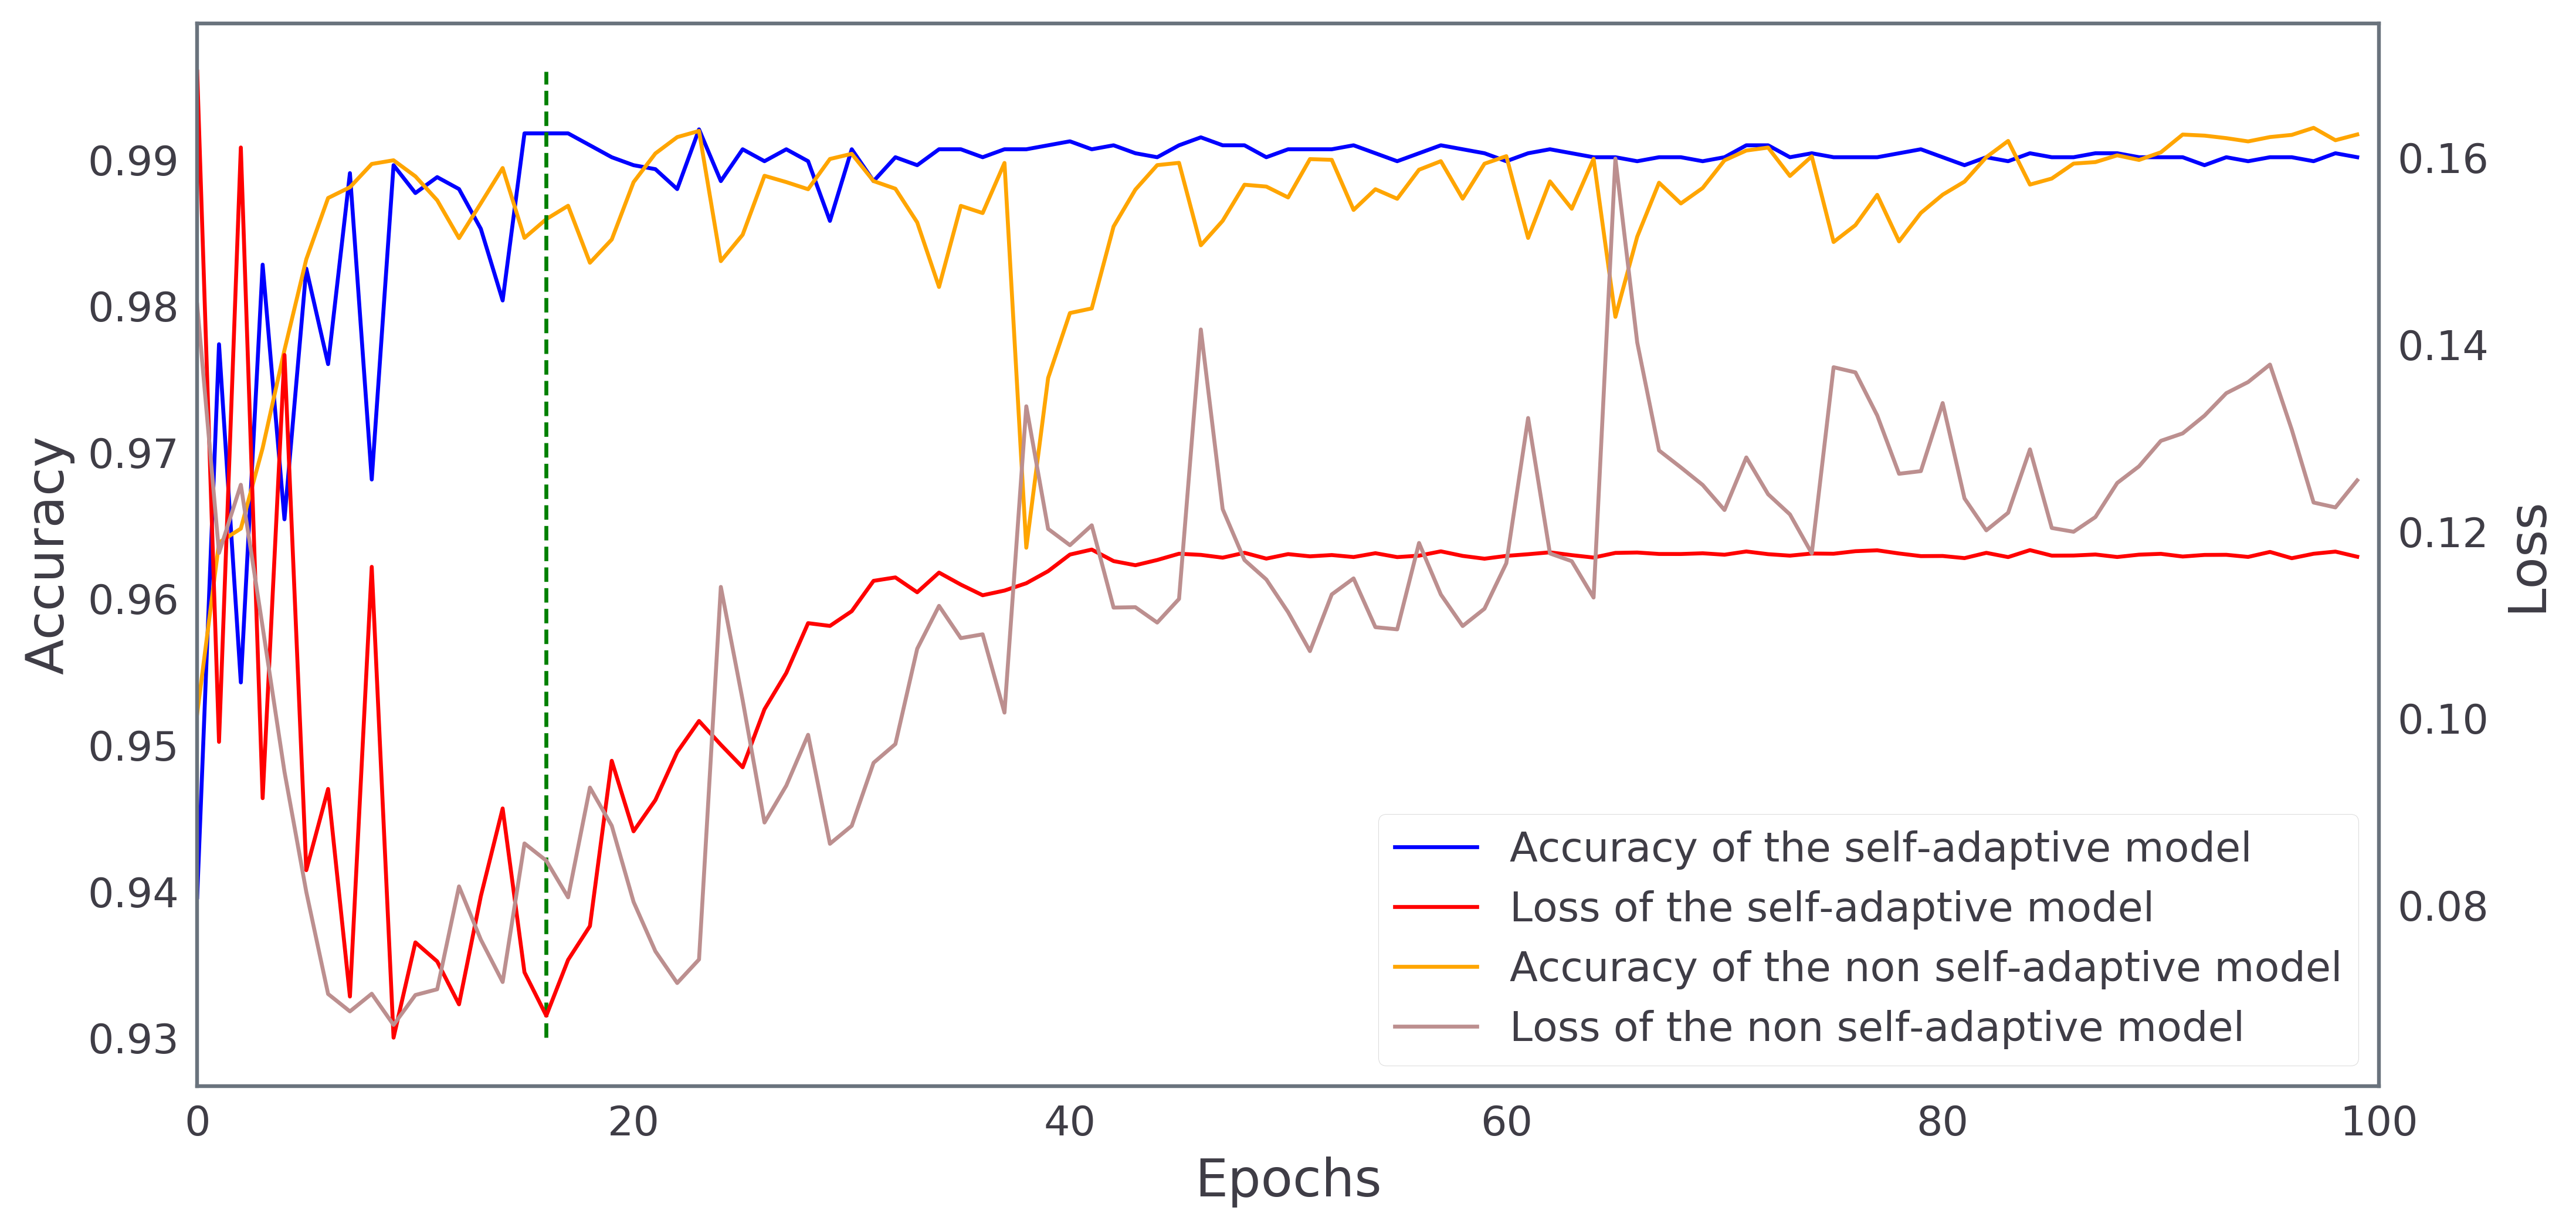

In [21]:
def smooth(scalars, weight):  # Weight between 0 and 1
        last = scalars[0]  # First value in the plot (first timestep)
        smoothed = list()
        for point in scalars:
            smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
            smoothed.append(smoothed_val)                        # Save it
            last = smoothed_val                                  # Anchor the last smoothed value
        return smoothed

fig = plt.figure(figsize=(12,6),dpi = 400)
ax1 = fig.add_subplot(111)
y1 = [i+0.007 for i in his['val_acc']]
y2 = his['val_loss']
y3 = [i+0.0065 for i in his2['val_acc']]
y4 = his2['val_loss']
s1 = smooth(y3,0.5)
s2 = smooth(y4,0.5)
x = np.arange(0,100)
z = 18
ln1 = ax1.plot(x, y1, 'blue',label = 'Accuracy of the self-adaptive model')
ln3 = ax1.plot(x, s1, 'orange', label = 'Accuracy of the non self-adaptive model',linestyle='-')
ax1.plot([16,16],[0.93,0.996],'green',linestyle = '--')
# ax1.plot(x = 18,np.arange(0,100))
ax1.set_ylabel('Accuracy',fontsize = 16)
ax1.set_xlabel('Epochs',fontsize = 16)
ax2 = ax1.twinx()  # this is the important function
ln2 = ax2.plot(x, y2, 'red',label = 'Loss of the self-adaptive model')
ln4 = ax2.plot(x, s2, 'rosybrown', label = 'Loss of the non self-adaptive model',linestyle='-')
# ax2.set_xlim([0, np.e])
ax2.set_ylabel('Loss',fontsize = 16)
# plt.xlabel('Epoch',fontsize = 16)

lns = ln1 + ln2 + ln3 + ln4
labs = [l.get_label() for l in lns]
print(labs)
ax1.legend(lns, labs, loc=4)
ax1.grid('off')
ax2.grid('off')
# ax1.grid()
# fig.legend(loc = 'lower right',bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.xlim([0.0, 100])
plt.grid('off')
plt.show()

# z = 18
# plt.plot(z)

(0, 100)

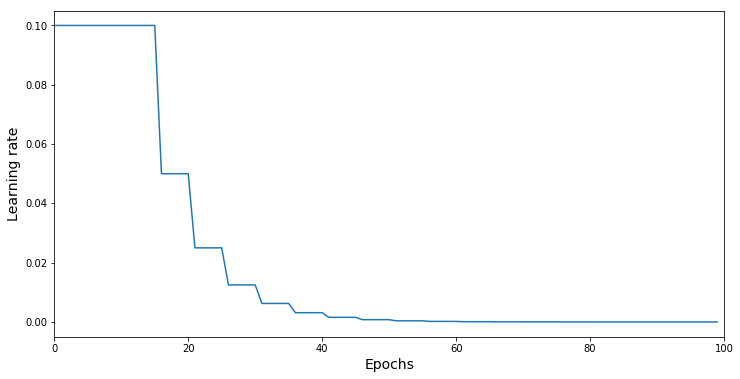

In [847]:
lr = his['lr']
fig = plt.figure(figsize=(12,6))
plt.plot(lr)
plt.ylabel("Learning rate",fontsize = 14)
plt.xlabel("Epochs",fontsize = 14)
plt.xlim([0,100])

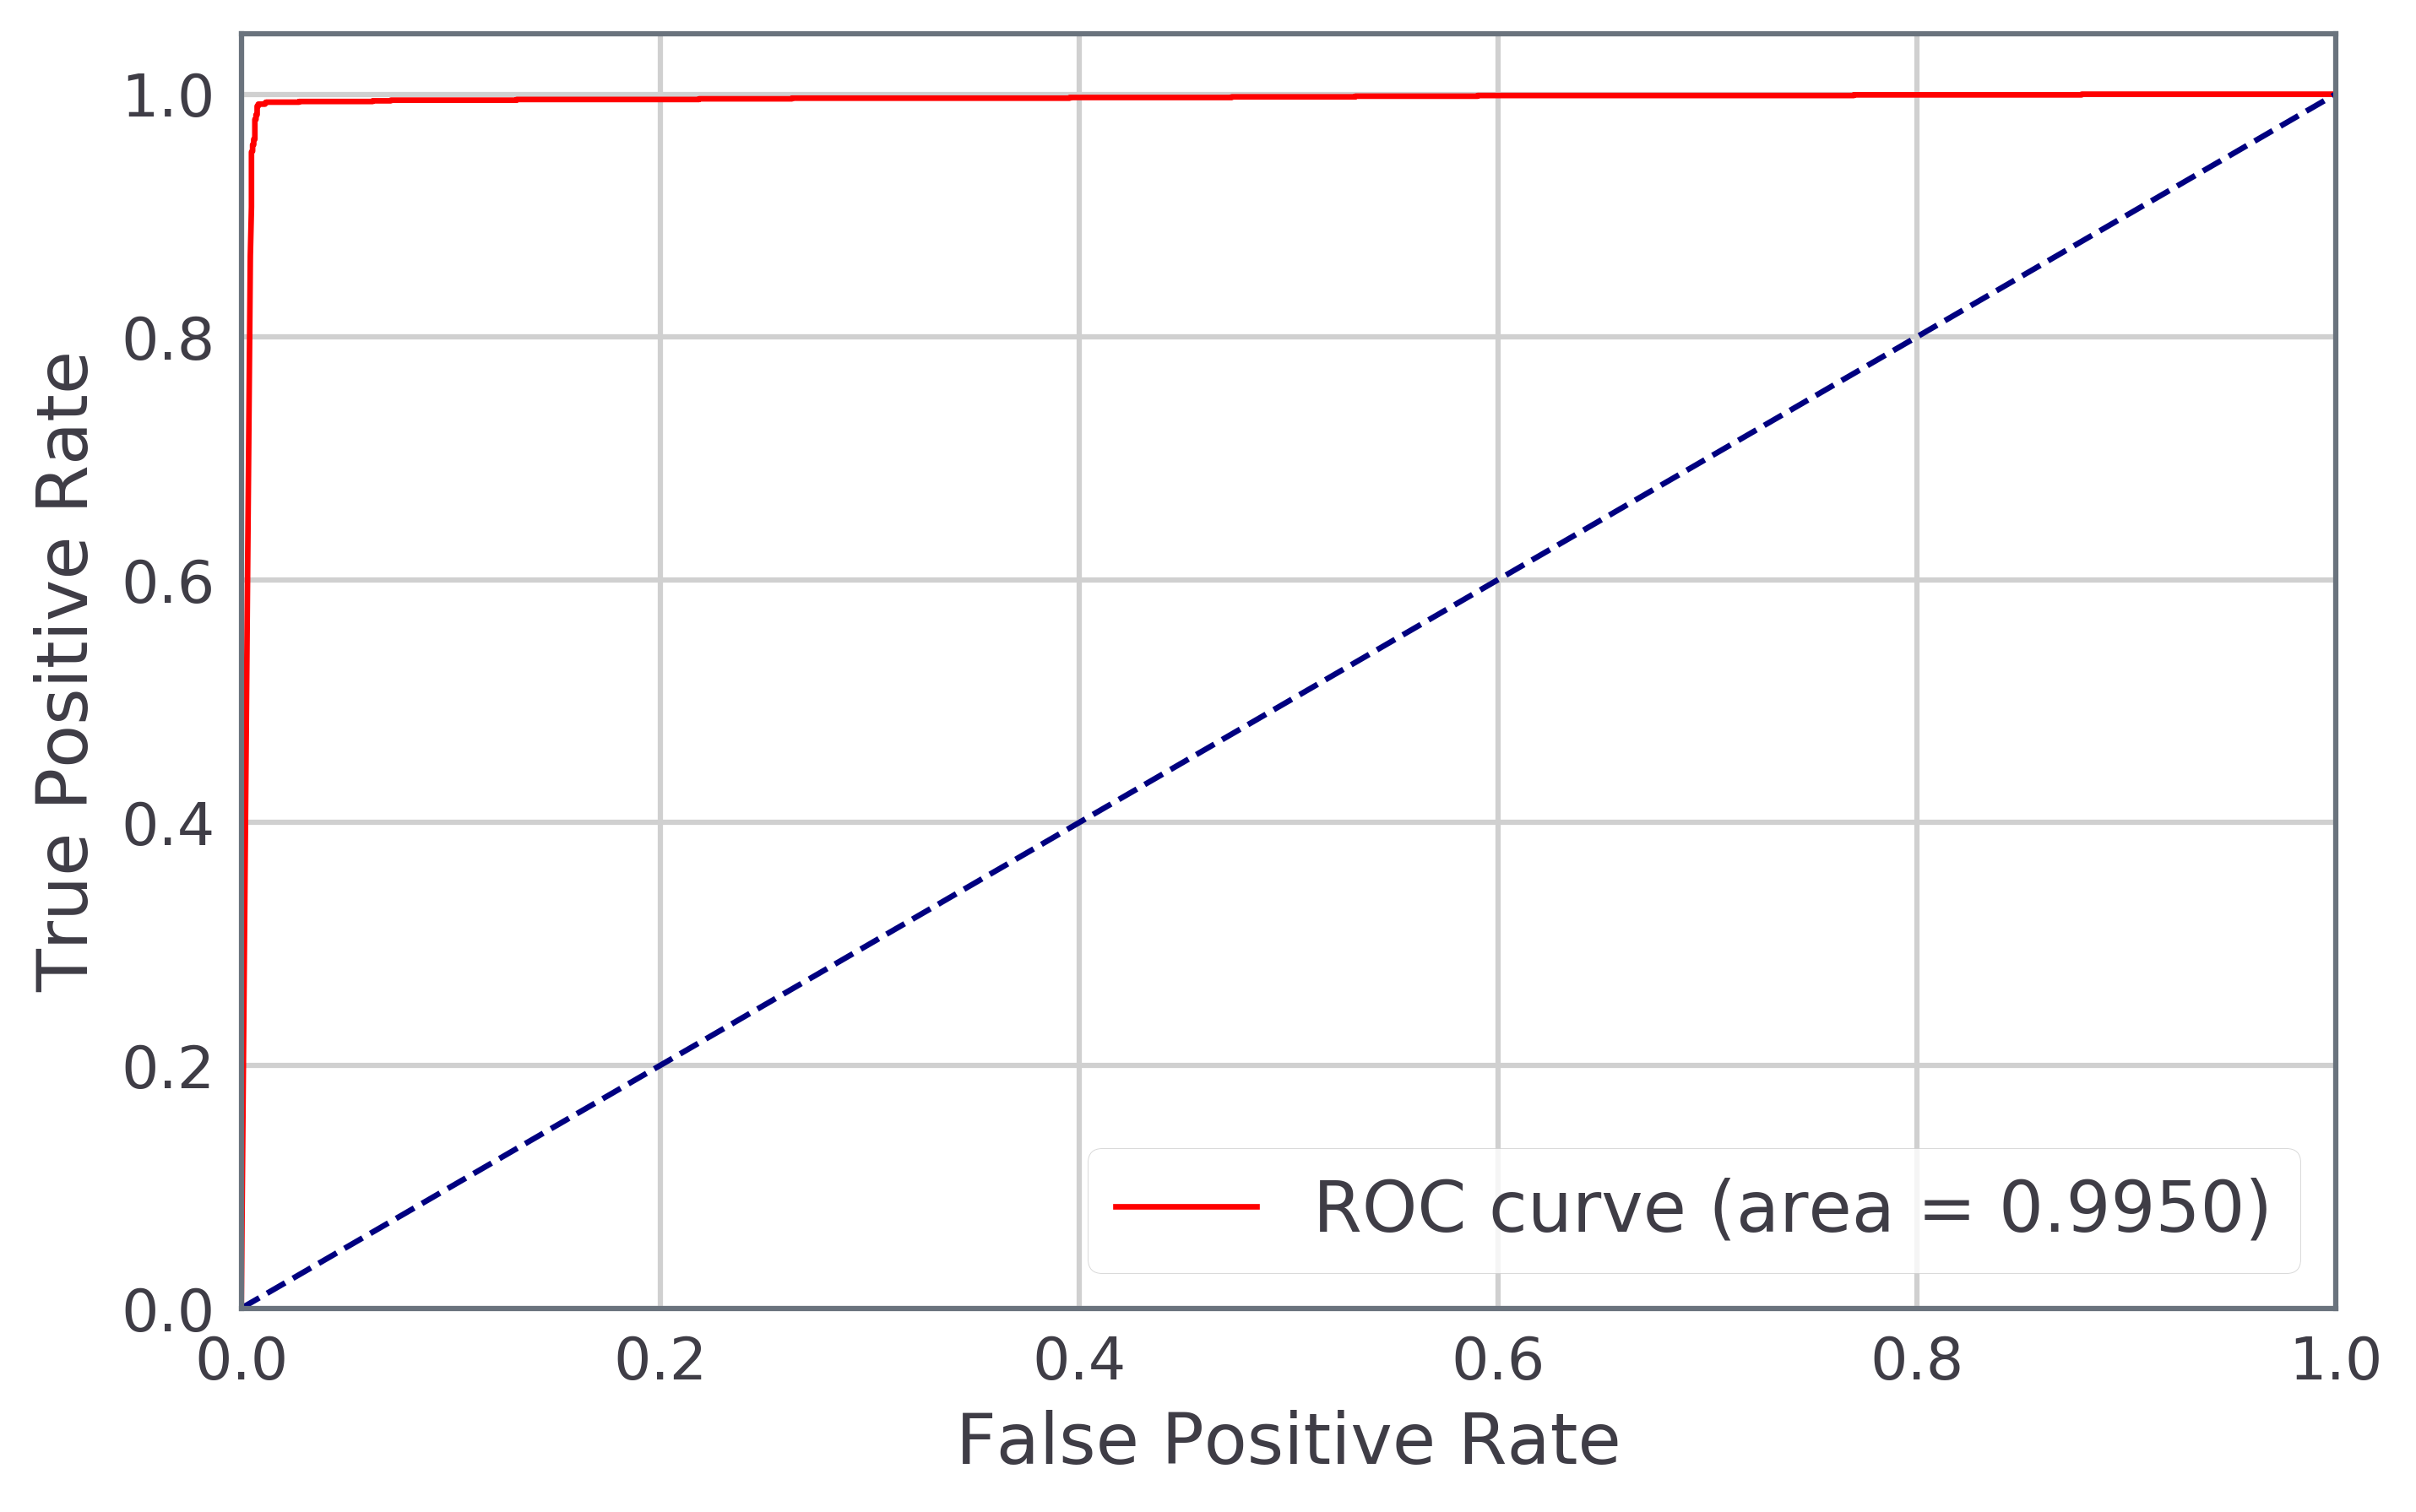

In [31]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_y, y_[:,1])
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8,5), dpi =400)
plt.plot(fpr, tpr, color='red',
          label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize = 15)
plt.ylabel('True Positive Rate',fontsize = 15)
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize=15)
plt.show()

In [32]:
# 计算置信区间
import numpy as np
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

y_pred = y_[:,1]
y_true = test_y

print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 50  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.995
Bootstrap #1 ROC area: 0.996
Bootstrap #2 ROC area: 0.991
Bootstrap #3 ROC area: 0.995
Bootstrap #4 ROC area: 0.996
Bootstrap #5 ROC area: 0.996
Bootstrap #6 ROC area: 0.994
Bootstrap #7 ROC area: 0.996
Bootstrap #8 ROC area: 0.995
Bootstrap #9 ROC area: 0.995
Bootstrap #10 ROC area: 0.995
Bootstrap #11 ROC area: 0.995
Bootstrap #12 ROC area: 0.994
Bootstrap #13 ROC area: 0.995
Bootstrap #14 ROC area: 0.996
Bootstrap #15 ROC area: 0.997
Bootstrap #16 ROC area: 0.996
Bootstrap #17 ROC area: 0.996
Bootstrap #18 ROC area: 0.996
Bootstrap #19 ROC area: 0.996
Bootstrap #20 ROC area: 0.994
Bootstrap #21 ROC area: 0.994
Bootstrap #22 ROC area: 0.996
Bootstrap #23 ROC area: 0.998
Bootstrap #24 ROC area: 0.995
Bootstrap #25 ROC area: 0.995
Bootstrap #26 ROC area: 0.994
Bootstrap #27 ROC area: 0.996
Bootstrap #28 ROC area: 0.994
Bootstrap #29 ROC area: 0.996
Bootstrap #30 ROC area: 0.995
Bootstrap #31 ROC area: 0.996
Bootstrap #32 ROC area: 0.995
Bootstrap #33 ROC area: 

/home/healgoo/.pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. Please call randint(0, 3678 + 1) instead


Bootstrap #247 ROC area: 0.995
Bootstrap #248 ROC area: 0.996
Bootstrap #249 ROC area: 0.993
Bootstrap #250 ROC area: 0.997
Bootstrap #251 ROC area: 0.997
Bootstrap #252 ROC area: 0.995
Bootstrap #253 ROC area: 0.995
Bootstrap #254 ROC area: 0.996
Bootstrap #255 ROC area: 0.995
Bootstrap #256 ROC area: 0.993
Bootstrap #257 ROC area: 0.994
Bootstrap #258 ROC area: 0.993
Bootstrap #259 ROC area: 0.995
Bootstrap #260 ROC area: 0.996
Bootstrap #261 ROC area: 0.996
Bootstrap #262 ROC area: 0.996
Bootstrap #263 ROC area: 0.997
Bootstrap #264 ROC area: 0.996
Bootstrap #265 ROC area: 0.995
Bootstrap #266 ROC area: 0.993
Bootstrap #267 ROC area: 0.993
Bootstrap #268 ROC area: 0.995
Bootstrap #269 ROC area: 0.993
Bootstrap #270 ROC area: 0.995
Bootstrap #271 ROC area: 0.996
Bootstrap #272 ROC area: 0.996
Bootstrap #273 ROC area: 0.997
Bootstrap #274 ROC area: 0.994
Bootstrap #275 ROC area: 0.995
Bootstrap #276 ROC area: 0.995
Bootstrap #277 ROC area: 0.994
Bootstrap #278 ROC area: 0.996
Bootstra

Bootstrap #748 ROC area: 0.995
Bootstrap #749 ROC area: 0.996
Bootstrap #750 ROC area: 0.995
Bootstrap #751 ROC area: 0.991
Bootstrap #752 ROC area: 0.996
Bootstrap #753 ROC area: 0.992
Bootstrap #754 ROC area: 0.996
Bootstrap #755 ROC area: 0.996
Bootstrap #756 ROC area: 0.995
Bootstrap #757 ROC area: 0.995
Bootstrap #758 ROC area: 0.996
Bootstrap #759 ROC area: 0.996
Bootstrap #760 ROC area: 0.994
Bootstrap #761 ROC area: 0.995
Bootstrap #762 ROC area: 0.993
Bootstrap #763 ROC area: 0.996
Bootstrap #764 ROC area: 0.998
Bootstrap #765 ROC area: 0.995
Bootstrap #766 ROC area: 0.995
Bootstrap #767 ROC area: 0.997
Bootstrap #768 ROC area: 0.995
Bootstrap #769 ROC area: 0.996
Bootstrap #770 ROC area: 0.994
Bootstrap #771 ROC area: 0.997
Bootstrap #772 ROC area: 0.997
Bootstrap #773 ROC area: 0.995
Bootstrap #774 ROC area: 0.996
Bootstrap #775 ROC area: 0.996
Bootstrap #776 ROC area: 0.995
Bootstrap #777 ROC area: 0.996
Bootstrap #778 ROC area: 0.995
Bootstrap #779 ROC area: 0.995
Bootstra

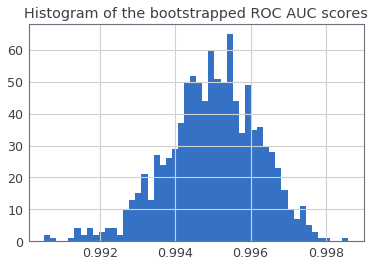

In [33]:
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [34]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.4f} - {:0.4}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.9929 - 0.9968]


In [76]:
y_[:,1]

array([1.1825134e-12, 1.0000000e+00, 9.9999809e-01, ..., 1.1637546e-11,
       1.0000000e+00, 1.0000000e+00], dtype=float32)

/home/healgoo/.pyenv/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


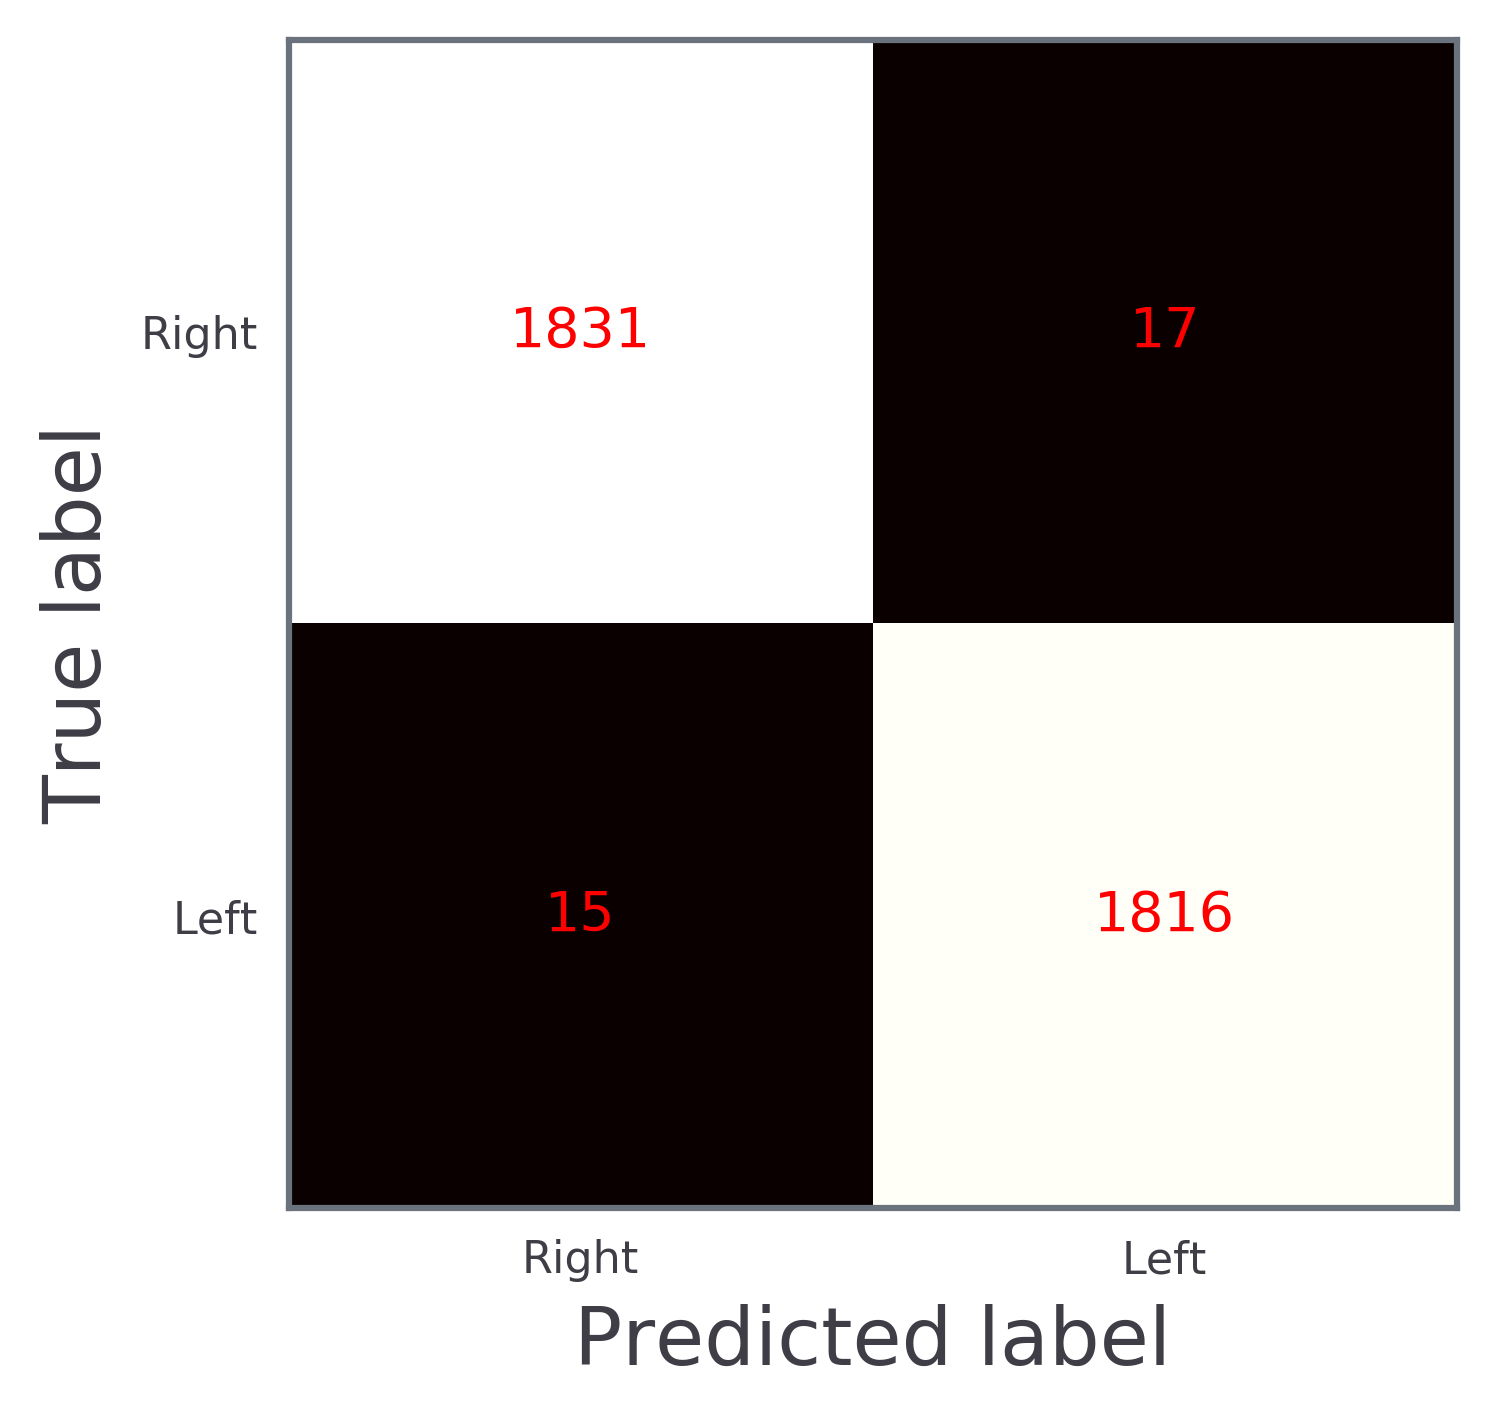

In [39]:
'''''compute confusion matrix 
labels.txt: contain label name. 
predict.txt: predict_label true_label 
'''  
from sklearn.metrics import confusion_matrix  
import matplotlib.pyplot as plt  
import numpy as np  
labels = ['Right', 'Left']
tick_marks = np.array(range(len(labels))) + 0.5  
# cmap = plt.cm.binary
def plot_confusion_matrix(cm, title='Confusion Matrix'):  
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.hot)  
    plt.title(title)  
    
    xlocations = np.array(range(len(labels)))  
    plt.xticks(xlocations, labels, rotation=0, fontsize = 8)  
    plt.yticks(xlocations, labels,fontsize = 8)  
    plt.ylabel('True label')  
    plt.xlabel('Predicted label')  
cm = confusion_matrix(test_y,result)
np.set_printoptions(precision=2)  
cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(4,4), dpi=400)  
#set the fontsize of label.  
#for label in plt.gca().xaxis.get_ticklabels():  
#    label.set_fontsize(8)  
#text portion  
ind_array = np.arange(len(labels))  
x, y = np.meshgrid(ind_array, ind_array)  

for x_val, y_val in zip(x.flatten(), y.flatten()):  
    c = cm[y_val][x_val]  
    if (c > 0.01):  
        plt.text(x_val, y_val, "%i" %(c,), color='red', fontsize=10, va='center', ha='center')  
#offset the tick  
plt.gca().set_xticks(tick_marks, minor=True)  
plt.gca().set_yticks(tick_marks, minor=True)  
plt.gca().xaxis.set_ticks_position('none')  
plt.gca().yaxis.set_ticks_position('none')  
# plt.grid(True, which='minor', linestyle='-') 
plt.grid('off')
plt.gcf().subplots_adjust(bottom=0.15)  
  
plot_confusion_matrix(cm, title = '')  
#show confusion matrix  
plt.show()

- 4.找出错误结果

In [36]:
y_ = list(y_)

In [37]:
def classication(m):
    return 0 if m[0]>=m[1] else 1
result = list(map(classication, y_))

In [38]:
result = np.array(result)
# y_true

In [597]:
index = np.argwhere(result != y_true)

In [598]:
y_[281]
# result[281]
y_true[281]

0

In [599]:
false_result_name = sum(test_X_name[index].tolist(), [])
path = './source_images/'
file_path = [''.join([path,file]) for file in false_result_name]

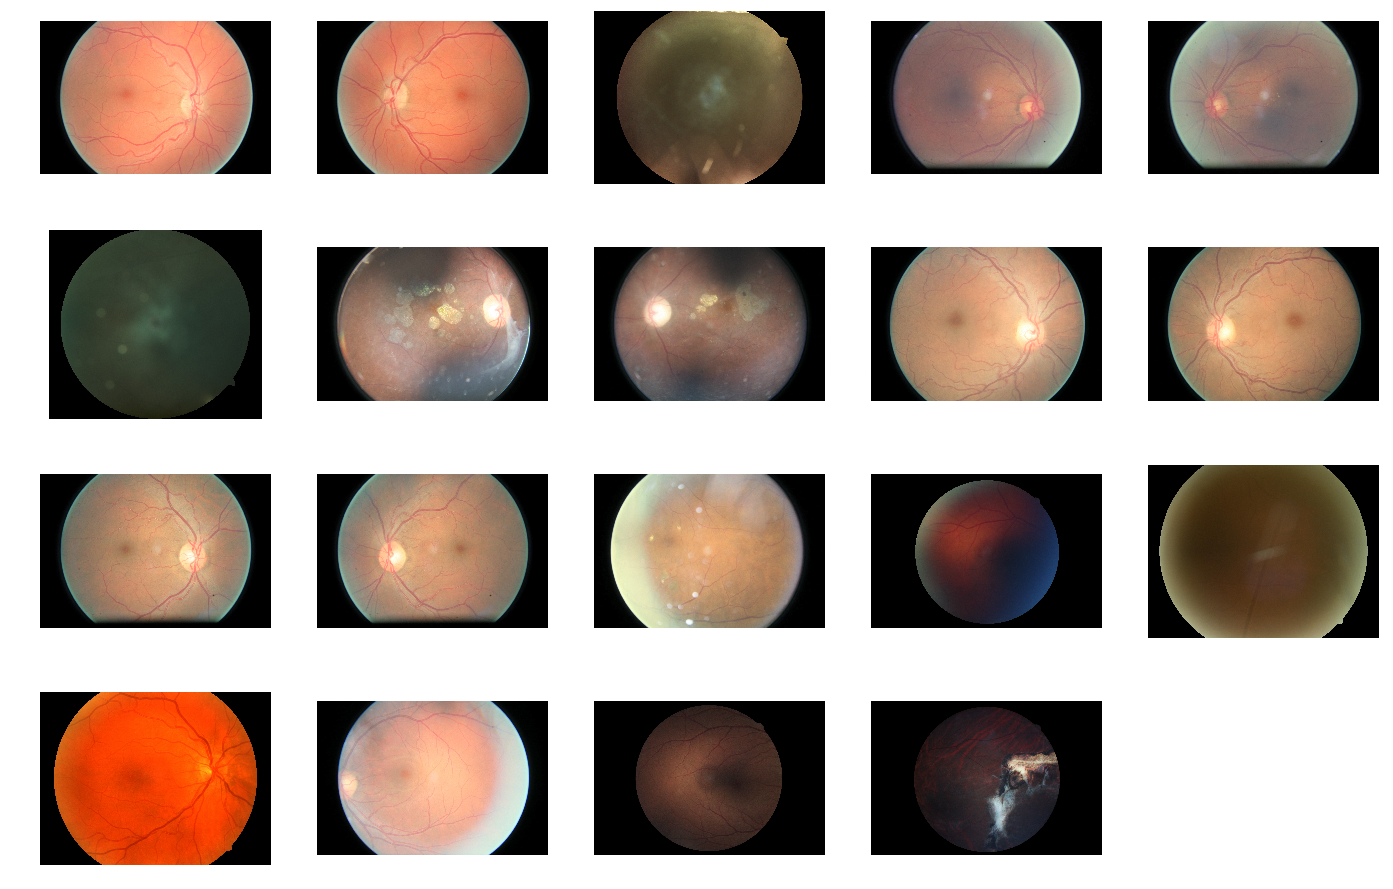

In [752]:
fig = plt.figure(figsize=(24,16))
for i,file in enumerate(file_path):
#     print(file)
#     file_path = ''.join([path,file])
# #     print(file_path)
    img = plt.imread(file, 1)
#     print(img.shape)
#     img = image_resize(img,(299,299))
    
    
    fig.add_subplot(4,5,i+1).imshow(img)
#     plt.text(y_true[index[i]],'Labeled by trained specialists: {}'.format(y_true[index[i]]), color='red', fontsize=10, va='center', ha='center')
#     plt.text(y_true[index[i]],result[index[i]], 'xx',color='red', fontsize=10, va='center', ha='center')
    plt.axis('off')

# file_path

In [606]:
test_X.shape

(2000, 299, 299, 3)

In [607]:
false_result_pre = np.squeeze(test_X[index])

In [608]:
false_result_pre.shape

(19, 299, 299, 3)

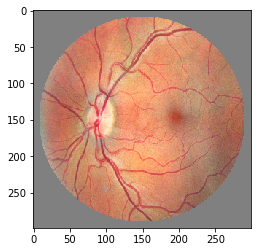

In [609]:
plt.imshow(false_result_pre[1][:,:,::-1])

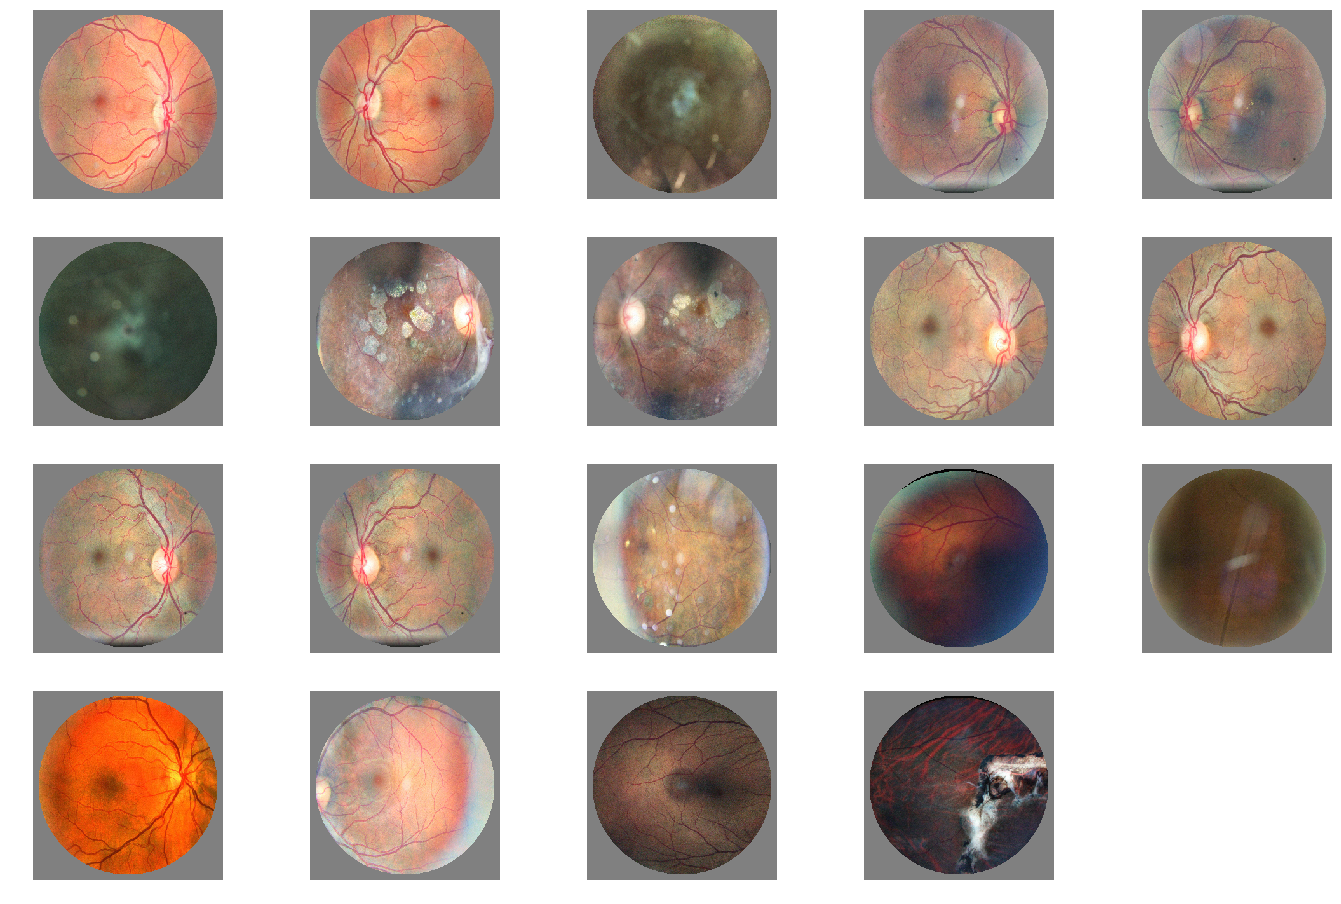

In [611]:
fig = plt.figure(figsize=(24,16))
for i,file in enumerate(false_result_pre):
#     print(file)
#     file_path = ''.join([path,file])
# #     print(file_path)
#     img = plt.imread(file, 1)
#     loc = '46{}'.format(i)
    fig.add_subplot(4,5,i+1).imshow(file[:,:,::-1])
    plt.axis('off')

In [754]:
index_false = np.argwhere(y_true[index] != result[index])

In [773]:
result[index]

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [772]:
y_true[index]

array([[1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1]])

- 5.CAM可视化

In [707]:
for i,layer in enumerate(model.layers):
    print(i,'->',layer.name,'->',layer.input_shape,'->',layer.output_shape)

0 -> input_1 -> (None, None, None, 3) -> (None, None, None, 3)
1 -> conv2d_1 -> (None, None, None, 3) -> (None, None, None, 32)
2 -> batch_normalization_1 -> (None, None, None, 32) -> (None, None, None, 32)
3 -> activation_1 -> (None, None, None, 32) -> (None, None, None, 32)
4 -> conv2d_2 -> (None, None, None, 32) -> (None, None, None, 32)
5 -> batch_normalization_2 -> (None, None, None, 32) -> (None, None, None, 32)
6 -> activation_2 -> (None, None, None, 32) -> (None, None, None, 32)
7 -> conv2d_3 -> (None, None, None, 32) -> (None, None, None, 64)
8 -> batch_normalization_3 -> (None, None, None, 64) -> (None, None, None, 64)
9 -> activation_3 -> (None, None, None, 64) -> (None, None, None, 64)
10 -> max_pooling2d_1 -> (None, None, None, 64) -> (None, None, None, 64)
11 -> conv2d_4 -> (None, None, None, 64) -> (None, None, None, 80)
12 -> batch_normalization_4 -> (None, None, None, 80) -> (None, None, None, 80)
13 -> activation_4 -> (None, None, None, 80) -> (None, None, None, 80)
1

In [713]:
layer_w = np.array(model.layers[1].get_weights())

layer_w = np.squeeze(layer_w)

layer_w.shape

(3, 3, 3, 32)

In [738]:
x = layer_w[:,:,:,0].astype('uint8')
x

array([[[ 53,  28,   7],
        [148,  34,  50],
        [  1,   2,   6]],

       [[ 23,  10,   2],
        [ 78,  11,  22],
        [  0,   0,   2]],

       [[  6,   0,  23],
        [  0,   0,   4],
        [  1,   1,  22]]], dtype=uint8)

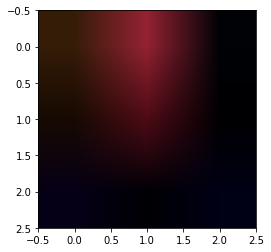

In [740]:
plt.imshow(x,interpolation = 'bilinear')

In [715]:
layer_w = np.power(layer_w,2) * 255

In [718]:
np.max(layer_w)
np.min(layer_w)

6.5303925e-06

In [710]:
minval= np.min(layer_w)
maxval = np.max(layer_w)
print(minval,maxval)
# min(min(min(min(layer_w)))) 
# maxval=max(max(max(max(layer_w))))
layer_w = (layer_w-minval)/maxval* 


-0.7624453 0.90784544


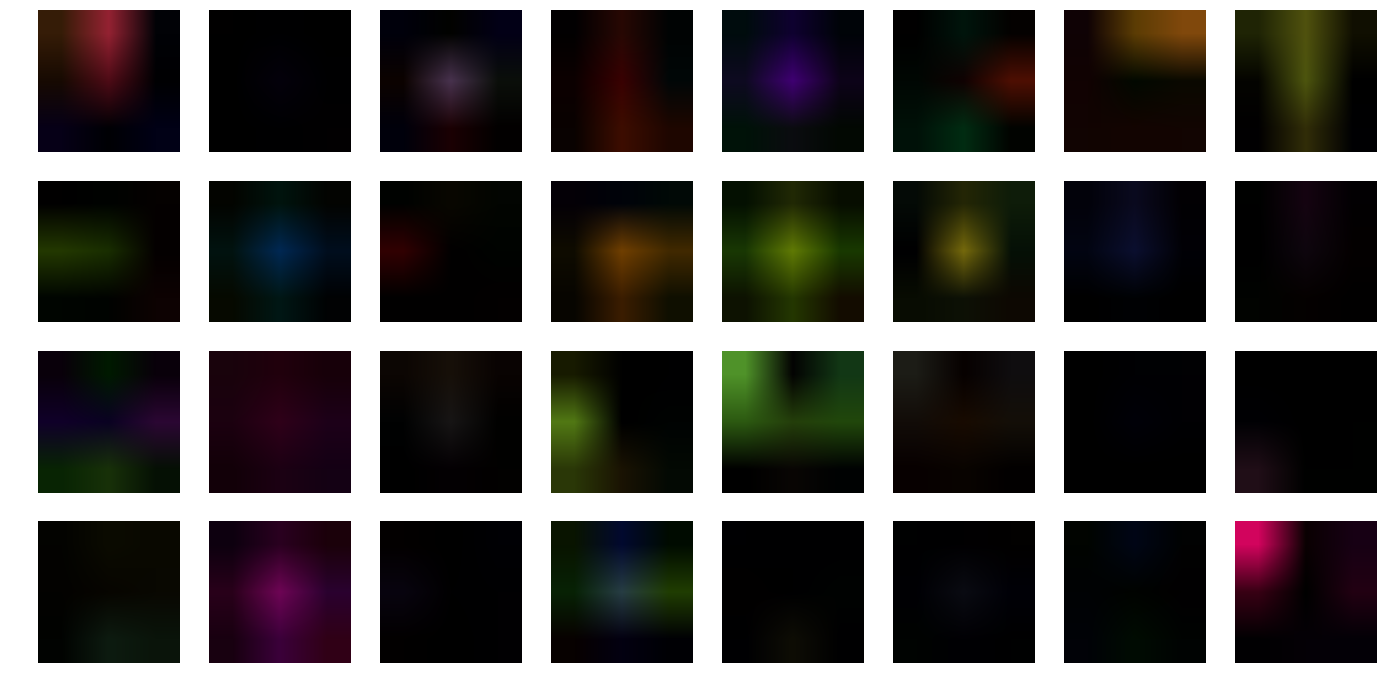

In [743]:
fig = plt.figure(figsize=(24,12))

for i in range(layer_w.shape[3]):
    fig.add_subplot(4,8,i+1).imshow(layer_w[:,:,:,i].astype('uint8'), interpolation = 'bilinear')
    plt.axis('off')
# plt.colorbar()

y2 = w2 * x + b2
y1 = w1 * y2 + b1

In [873]:
basemodel = model
new_model = keras.models.Model(inputs = basemodel.input,outputs=basemodel.get_layer('mixed10').output)

In [874]:
w1 = np.array(model.layers[-2].get_weights())[0]
b1 = np.array(model.layers[-2].get_weights())[1]

w2 = np.array(model.layers[-1].get_weights())[0]
b2 = np.array(model.layers[-1].get_weights())[1]

(-0.5, 7.5, 7.5, -0.5)

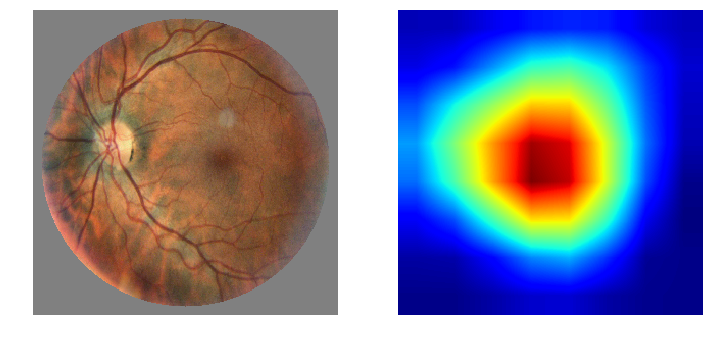

In [1178]:
index = 14
img = test_X[index][np.newaxis,:,:,:]
x = new_model.predict(img)

y1 = np.dot(x,w1) + b1
y2 = np.dot(y1,w2) + b2
y2 = np.squeeze(y2)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(test_X[index][:,:,::-1])
ax2.imshow(y2[:,:,1],cmap = 'jet',interpolation = 'bilinear')
ax1.axis('off')
ax2.axis('off')

-------------------------------------------------